In [1]:
#interactive plots
%matplotlib notebook

from pylab import *
rcParams['figure.figsize']=[11,8]

from scipy.special import erf
from scipy.stats import norm
from scipy.optimize import leastsq

import matplotlib.cm as cm
import matplotlib.colors as colors

sys.path.append('/Users/xavierdumusque/uni/phd/program/functions/')
sys.path.append('/Users/xavierdumusque/uni/phd/program/convective_blueshift/')
sys.path.append('/Library/Python/2.7/site-packages')

import glob,os,sys,string
import pyrdb
import functions
import read_spectrum_star
import calculate_spectrum
import planet
import stats
import copy
import fit2
import fit
import pyfits
import pandas as pd
from scipy.stats import pearsonr
import corner
import lmfit


########################################################
#para
########################################################

Select the star, can be HD128621, HD215152, HD192310

In [2]:
star = 'HD128621' # raw_input('For which star do you want to extract the CCFs and other infos: ')

In [3]:
#CCF fits files for HD128621
CCF_file_folder = '/Users/xavierdumusque/uni/phd/program/skewness_CCF/data/HD128621/'

#file with good meaurements for HD128621
HD128621_good_meas = '/Users/xavierdumusque/uni/phd/data/dbase/stars_old_but_after_alpha_cen_b/HD128621_harps_cleaned_corrected_orb_mot.rdb'

In [4]:
data_ccf_file = 'data/'+star+'_CCF.rdb'
data_file = 'data/'+star+'_data.rdb'

if star == 'HD215152':
    chi_square_cut = 5e-6
else:
    chi_square_cut = 0.001

########################################################
#read CCFs
########################################################

selecting data
end selecting data

NOT USING RESIDUALS

0  over  2038


<IPython.core.display.Javascript object>


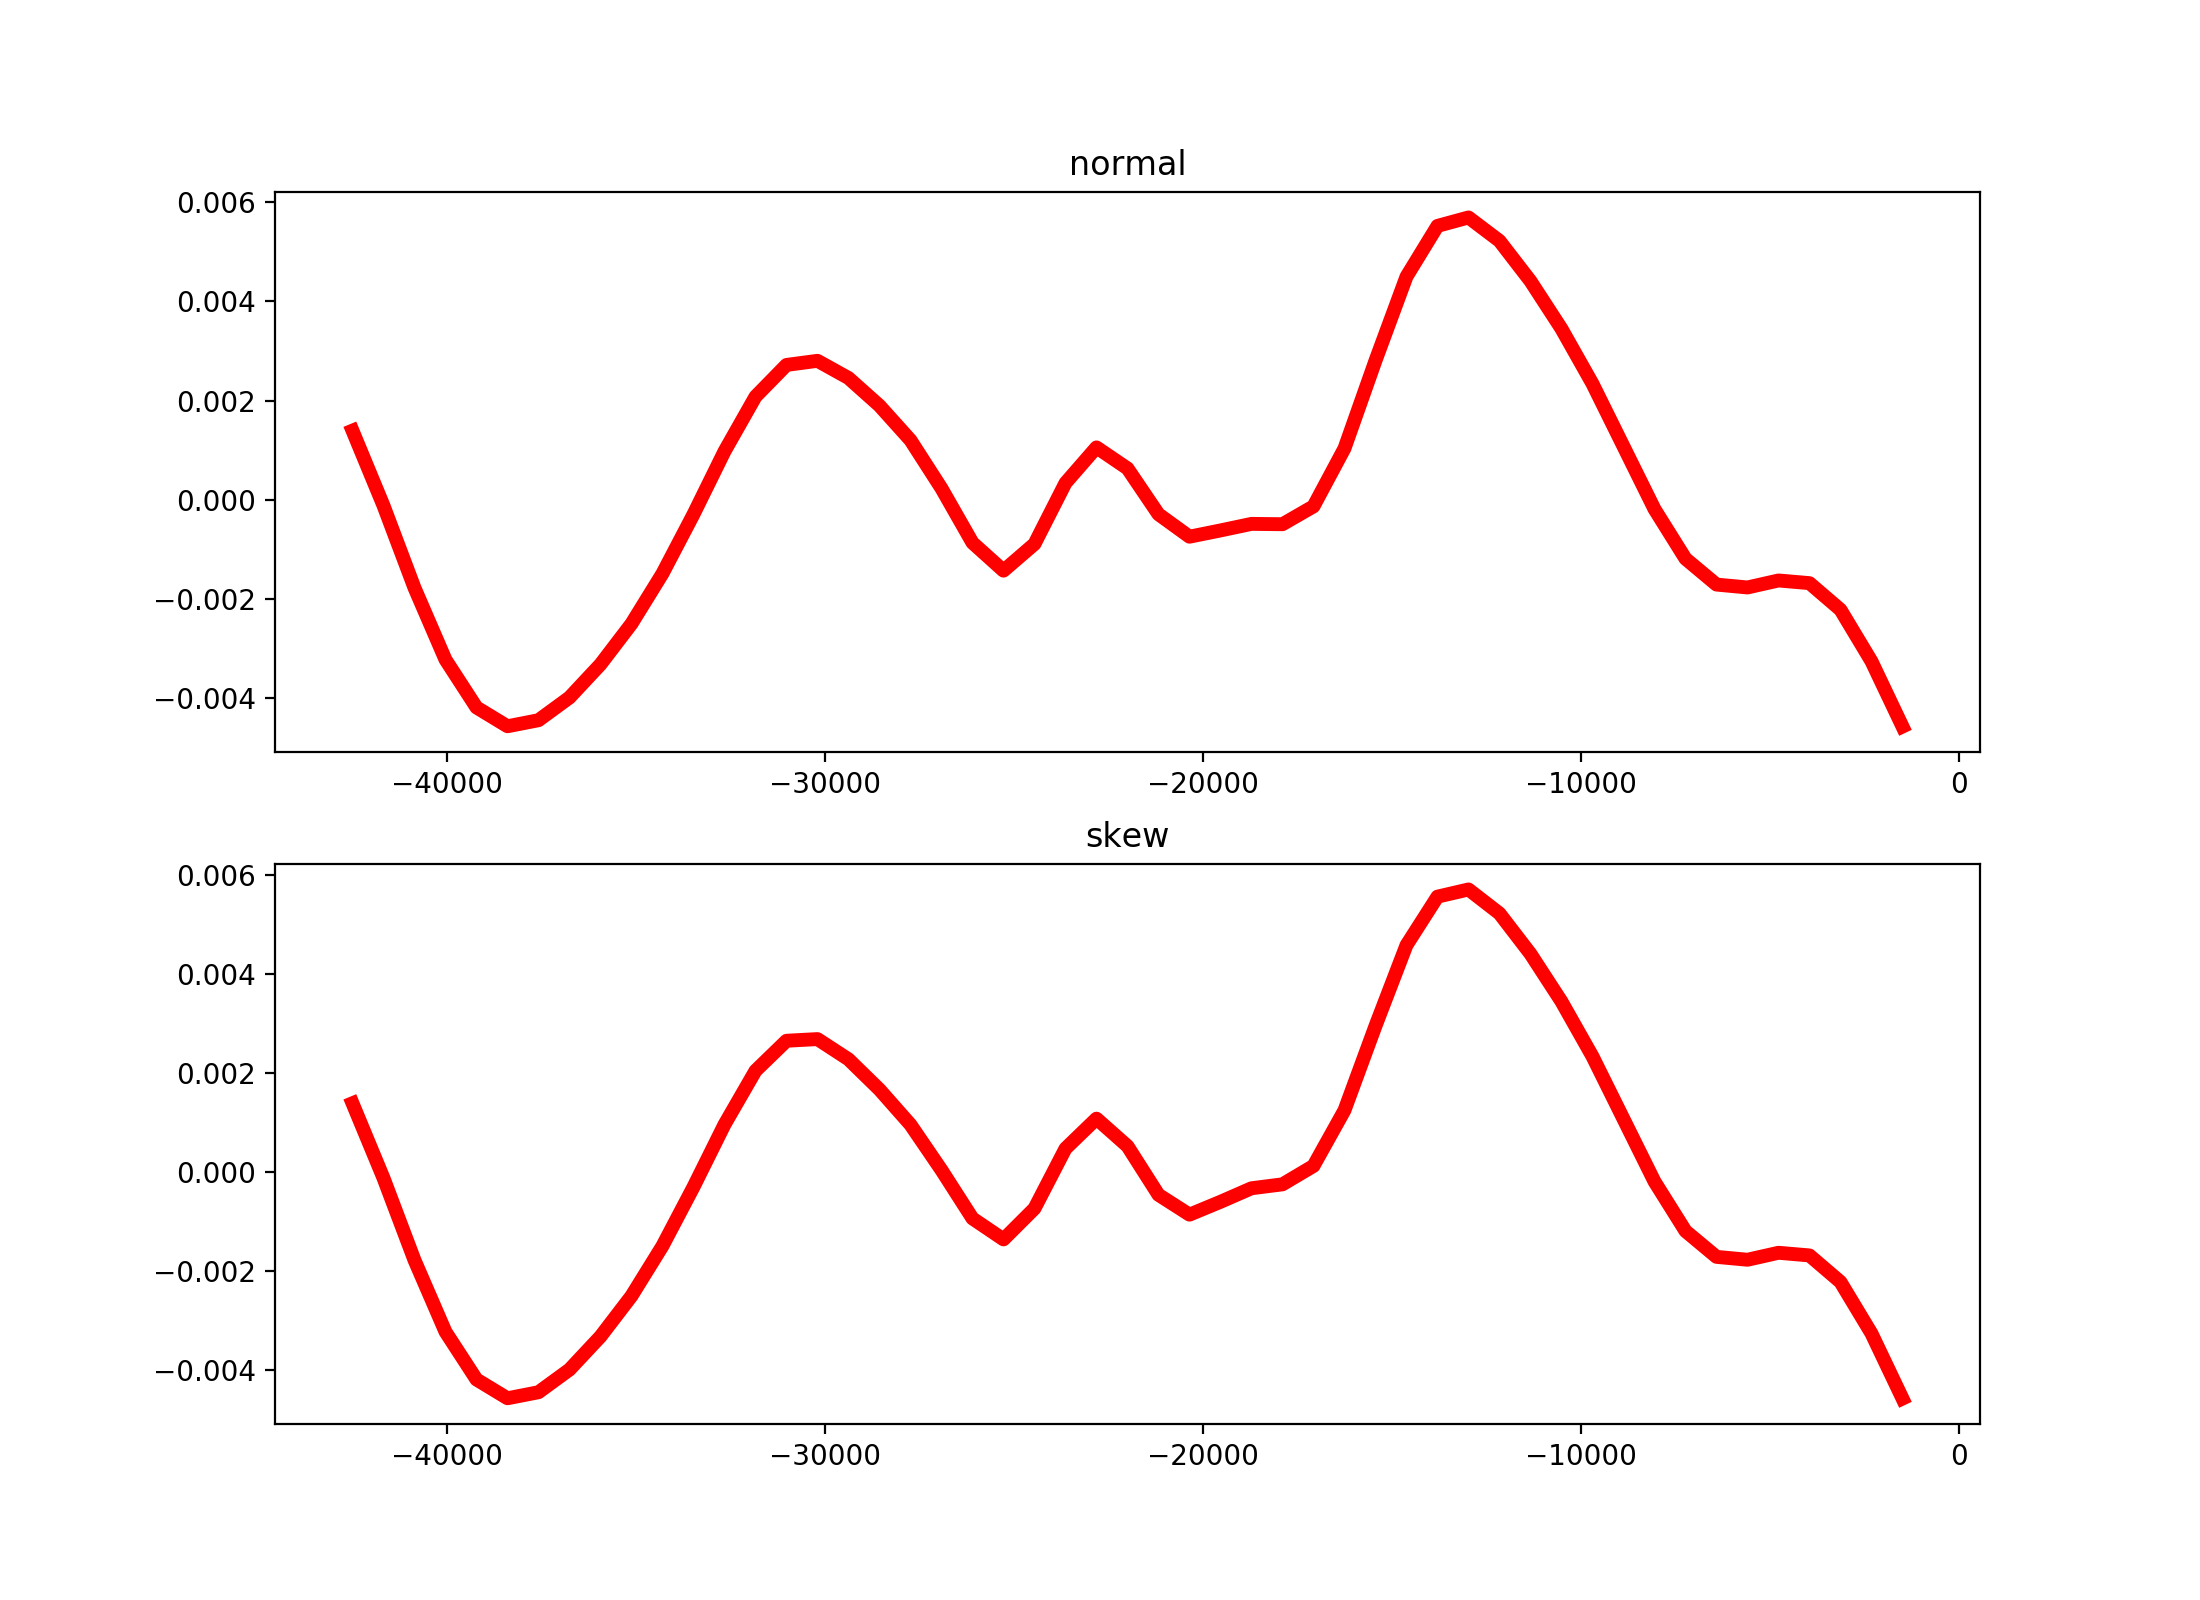

<IPython.core.display.Javascript object>


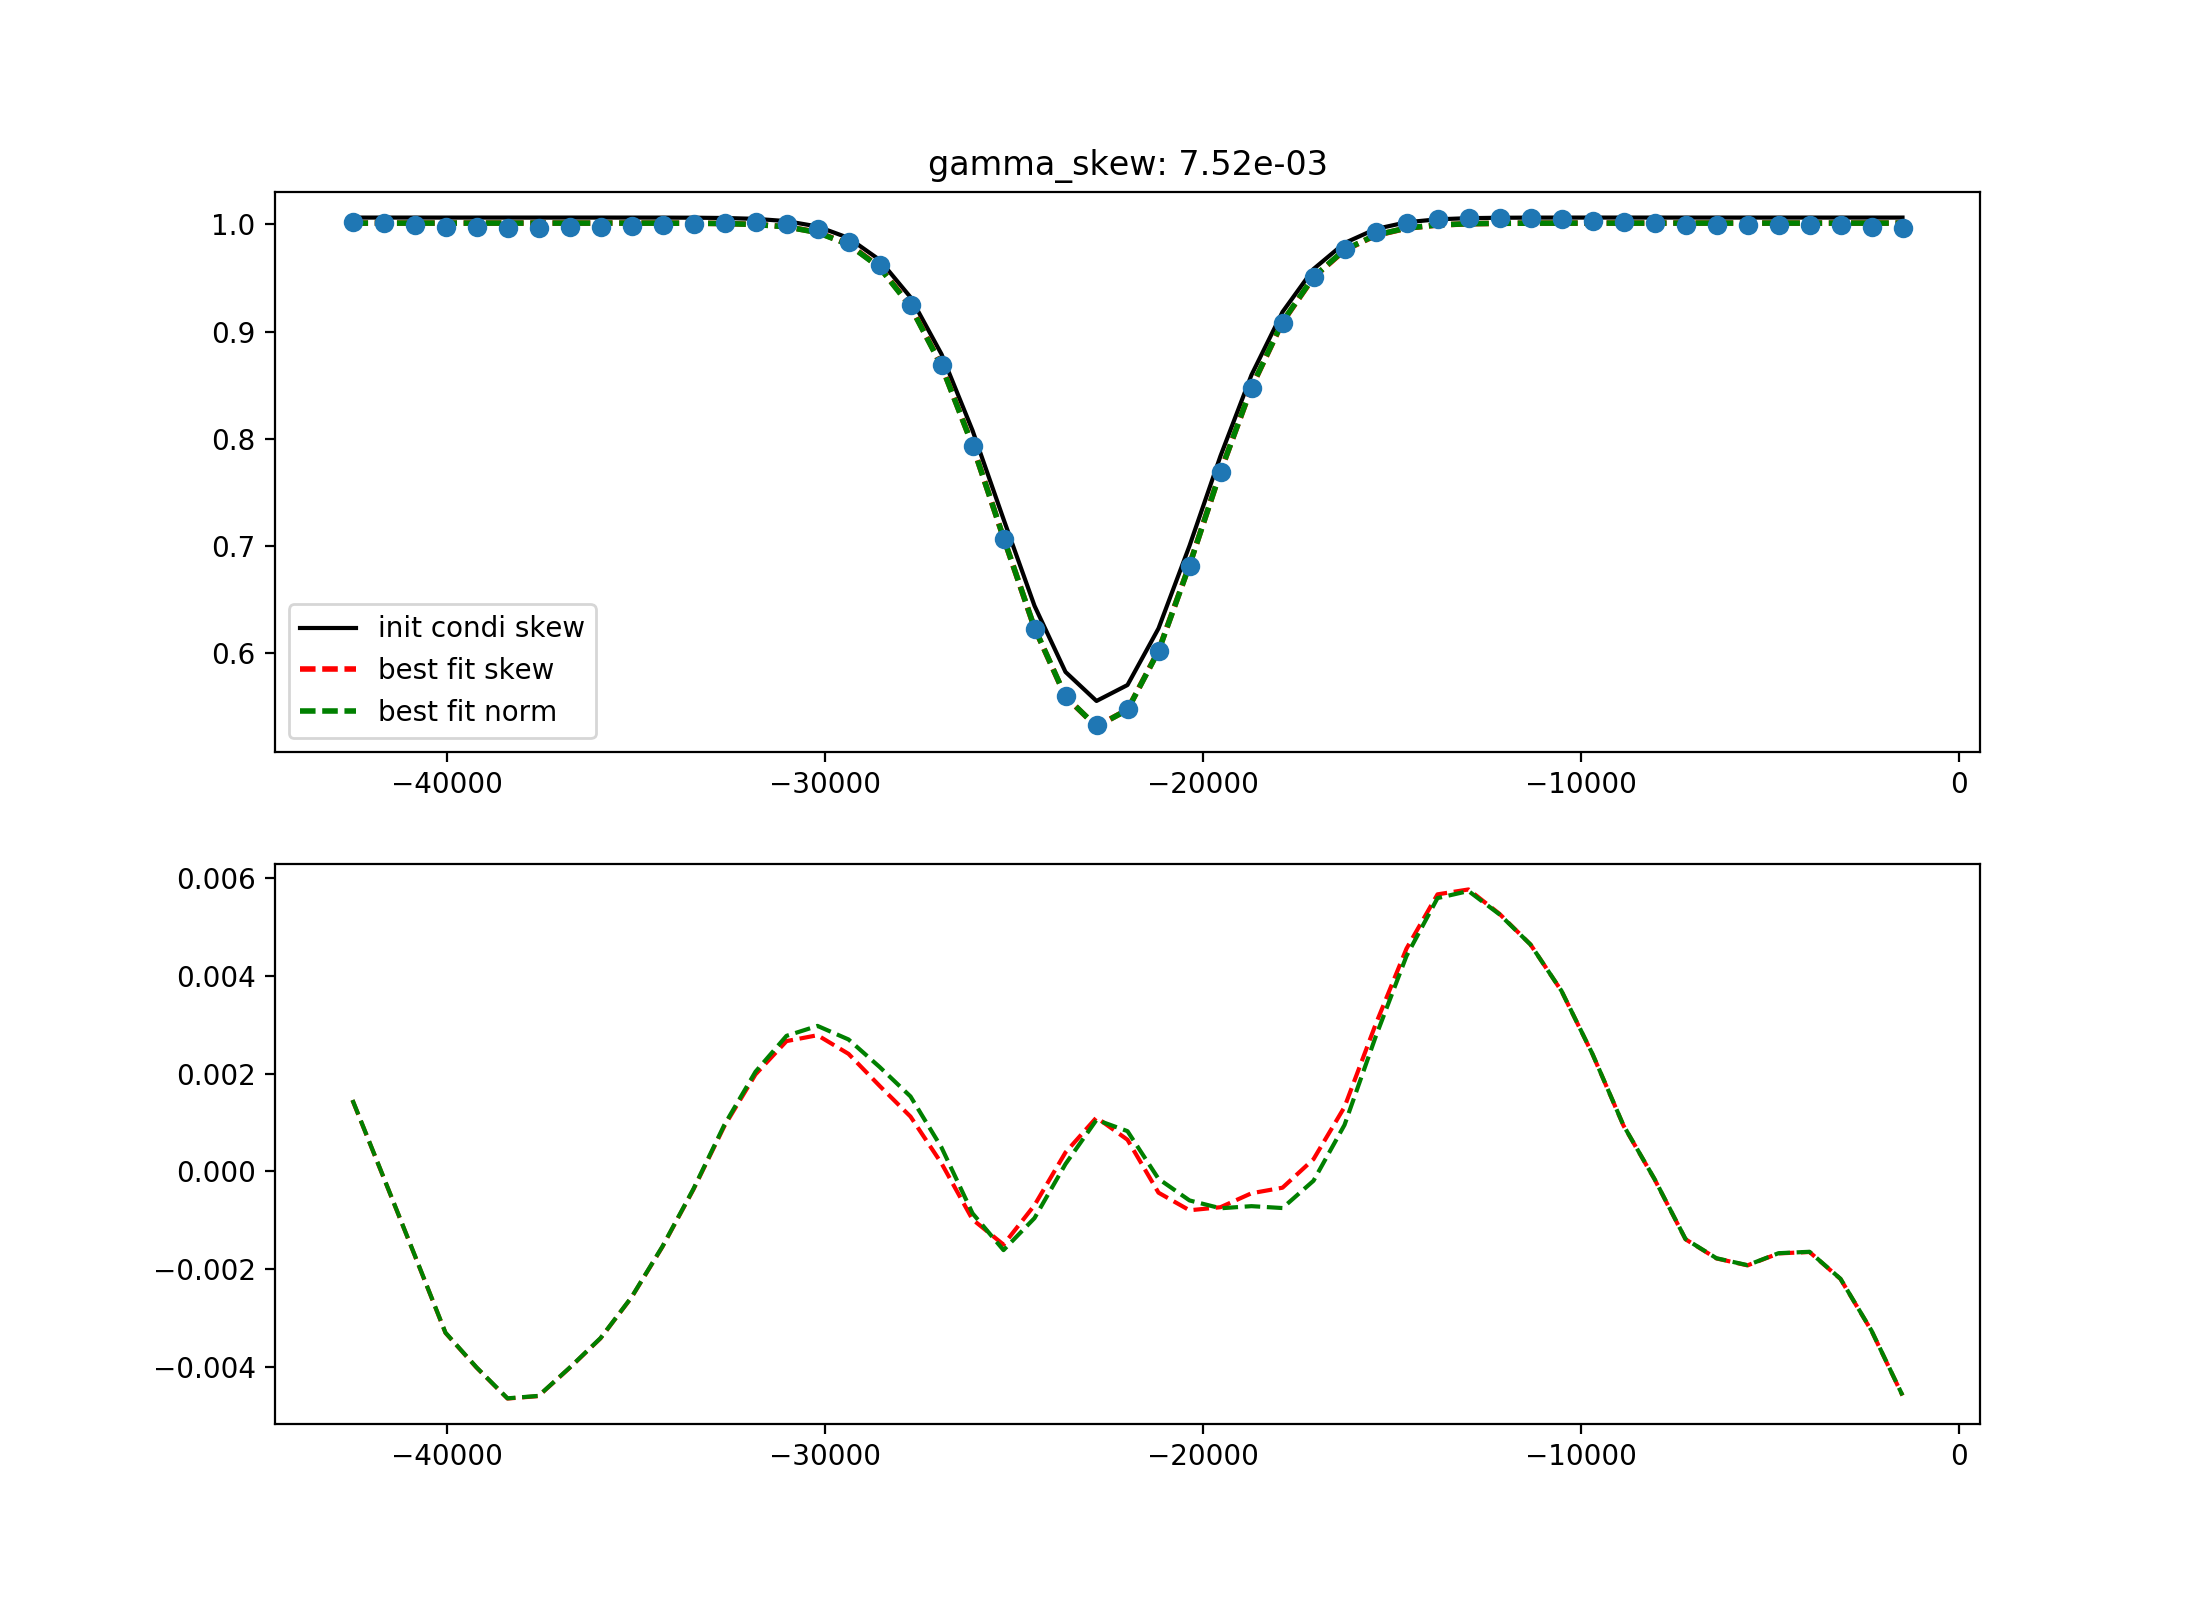

<IPython.core.display.Javascript object>


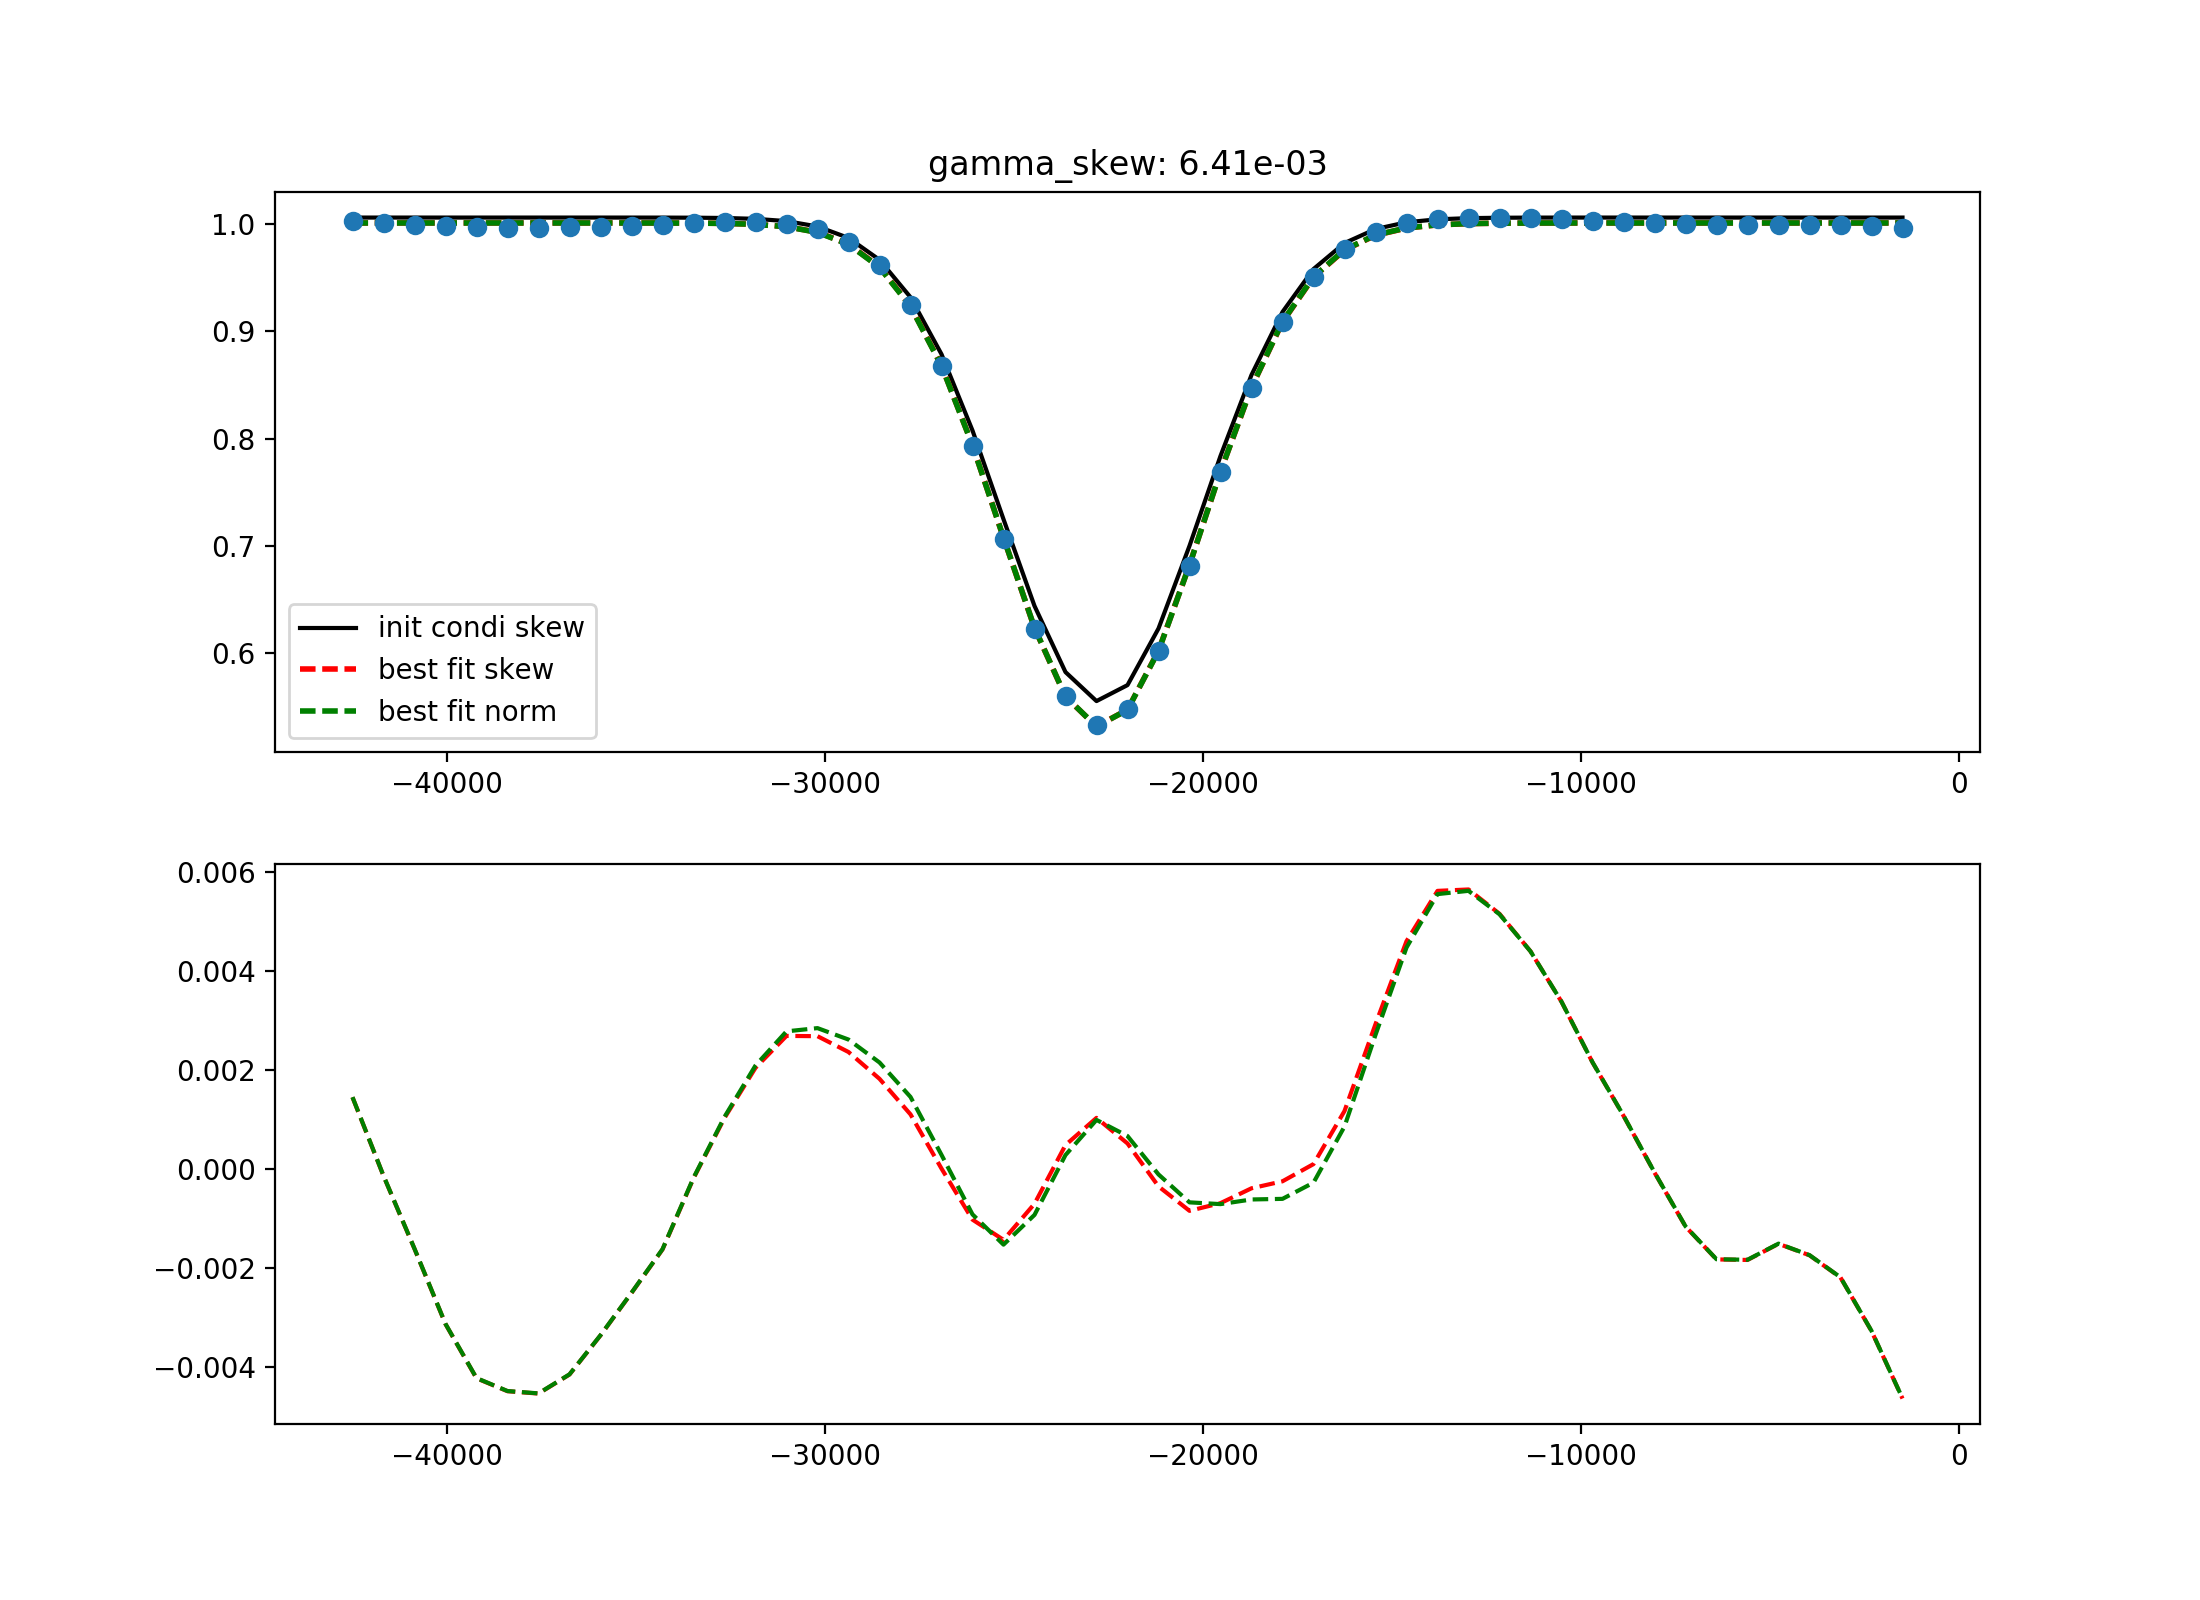

50  over  2038
100  over  2038
150  over  2038
200  over  2038
250  over  2038
300  over  2038
350  over  2038
400  over  2038
450  over  2038
500  over  2038
550  over  2038
600  over  2038
650  over  2038
700  over  2038
750  over  2038
800  over  2038
850  over  2038
900  over  2038
950  over  2038
1000  over  2038
1050  over  2038
1100  over  2038
1150  over  2038
1200  over  2038
1250  over  2038
1300  over  2038
1350  over  2038
1400  over  2038
1450  over  2038
1500  over  2038
1550  over  2038
1600  over  2038
1650  over  2038
1700  over  2038
1750  over  2038
1800  over  2038
1850  over  2038
1900  over  2038
1950  over  2038
2000  over  2038


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [5]:
data = pd.read_csv(data_file,sep='\t',skiprows=[1])
sn50     = array(data['sn50'])
time     = array(data['time'])
nb_obs = len(time)

if star == 'HD128621':
    #Read good meas
    data_good_meas = pd.read_csv(HD128621_good_meas,sep='\t',skiprows=[1])
else:
    data_good_meas = pd.read_csv('/Users/xavierdumusque/uni/phd/data/dbase/stars/'+star+'_harps.rdb',sep='\t',skiprows=[1])

select_good_meas = zeros(len(time),'bool')
print "selecting data"
for i,t in enumerate(time-2400000):
    if min(abs(t - data_good_meas['jdb'])) < 1.e-4:
        select_good_meas[i] = 1.
    
if star == 'HD128621':
    select = (time > 2455198.03009) & (time < 2455563.03009) #data in 2010
elif star == 'HD10700':
    select = (time > 2456000) & (time < 2457158)
else:
    select = (time > 2454500) & (time < 2457158)

select = select * select_good_meas
print "end selecting data"

#read data
variables = ['time','rv','rvc','bis_span','fwhm','contrast','sn50','noise','s_mw','sig_s_mw','rhk','sig_rhk']
for var in variables:
    exec var+" = array(data[var][select])"

rv *= 1000.
rvc *= 1000.
fwhm *= 1000.
noise *= 1000.

# Get the correction drift that has been applied to the RV (from simultaneous thorium)
rv_drift = rvc - rv

#read ccf
data_ccf = pd.read_csv(data_ccf_file,sep='\t',skiprows=[1])
select_ccf = arange(nb_obs)[select]
vrad = array(data_ccf['rv']) * 1000.
CCF = [array(data_ccf['CCF_'+str(i)]) for i in select_ccf]
CCF_noise = [array(data_ccf['CCF_noise_'+str(i)]) for i in select_ccf]

skew_fit,normal_fit,chi_square,bad_residuals,bad_points,RV_precision_ccf,RV_precision_ccf2 = [],[],[],[],[],[],[]
sum_residual_skew = 0
sum_residual_normal = 0
residual_used = 0

use_res = '0'

if os.path.exists('data/%s_ccf_residuals.rdb' % star) and use_res == '1':
    data_residuals_ccf = pyrdb.read_rdb('data/%s_ccf_residuals.rdb' % star)
    ccf_residuals_skew = array(data_residuals_ccf['skew_residuals'])
    ccf_residuals_norm = array(data_residuals_ccf['norm_residuals'])
    print
    print 'USING RESIDUALS'
    print
else:
    ccf_residuals_skew = zeros(len(vrad))
    ccf_residuals_norm = zeros(len(vrad))
    print
    print 'NOT USING RESIDUALS'
    print

bad_points = zeros(len(time),'bool')

CCF_skew = zeros(shape(CCF))
CCF_norm = zeros(shape(CCF))

for i in arange(len(CCF)):

    if i%50 == 0:
        print i, ' over ',len(CCF)

    max_CCF = median(sort(CCF[i])[-30:])
    CCF_skew[i] = CCF[i]/max_CCF - ccf_residuals_skew
    CCF_norm[i] = CCF[i]/max_CCF - ccf_residuals_norm
    CCF_noise[i] = CCF_noise[i]/max_CCF

    #model,continuum,contrast,span,vrad,fwhm,depth,bis_span
#    mod,solution,init_mod,chi2,chi2_red,e,w,a = functions.fit_skew_distribution_for_CCF(vrad,CCF[i],3000.,rv[i],fwhm[i],method='leastsq')
#    skew_fit.append(functions.fit_skew_distribution_for_CCF(vrad,CCF[i],solution['ampli'],solution['mu'],solution['sigma'],cte=solution['cte'],gamma=solution['gamma'],method='leastsq'))
    skew_fit.append(functions.fit_skew_distribution_for_CCF(vrad,CCF_skew[i],CCF_noise[i],3000.,rv[i],fwhm[i],method='leastsq',mcmc=False))
    normal_fit.append(fit2.gauss_bis(vrad,CCF_norm[i],CCF_noise[i],ones(100)))
    #normal_fit.append(functions.fit_norm_distribution_for_CCF(vrad,CCF_norm[i],ones(len(CCF_noise[i])),0.5,rv[i],fwhm[i],method='leastsq',mcmc=False))

    dx = vrad[2:]-vrad[:-2]
    dy = CCF_skew[i][2:]-CCF_skew[i][:-2]
    sig_dy = CCF_noise[i][1:-1]
    slope_CCF = dy/dx
    sig_slope = sig_dy/dx
    RV_precision_ccf = append(RV_precision_ccf,(sum(slope_CCF**2/sig_dy**2))**(-0.5)) #voir "off_make_ccf_harps.py"
    RV_precision_ccf2 = append(RV_precision_ccf2,(sum(1./(2*sig_dy**2/slope_CCF**2)))**(-0.5))

    if skew_fit[-1][-1]:
        res = skew_fit[-1][-1]
        print lmfit.report_fit(res.params)
        figure(1000+i)
        corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()))

    figure(100)
    if i==0:
        sum_residual_skew += (CCF_skew[i] - skew_fit[-1][0])
        sum_residual_normal += (CCF_norm[i] - normal_fit[-1][0])
        residual_used += 1
    else:
        chi_square = append(chi_square,sum((CCF_skew[i] - skew_fit[-1][0] - sum_residual_skew/residual_used)**2))
        if chi_square[-1] < chi_square_cut:
            sum_residual_skew += (CCF_skew[i] - skew_fit[-1][0])
            sum_residual_normal += (CCF_norm[i] - normal_fit[-1][0])
            residual_used += 1
        else:
            bad_residuals.append(bad_residuals)
            subplot(211)
            plot(vrad,(CCF_skew[i] - skew_fit[-1][0]),label='skew %.2e' % (skew_fit[i][1]['gamma']),color='b',lw=3)
            subplot(212)
            plot(vrad,(CCF_norm[i] - normal_fit[-1][0]),color='b',lw=3)
            bad_points[i] = 1


    if i<2:
        figure(i)
        subplot(211)
        title('gamma_skew: %.2e' % skew_fit[i][1]['gamma'])
        errorbar(vrad,CCF_skew[i],CCF_noise[i],marker='o',ls='')
        plot(vrad,skew_fit[-1][2],color='k',ls='-',label = 'init condi skew')
        #plot(vrad,normal_fit[-1][2],color='k',ls='-',label = 'init condi norm')
        plot(vrad,skew_fit[-1][0],color='r',ls='--',label = 'best fit skew',lw=2)
        plot(vrad,normal_fit[-1][0],color='g',ls='--',label = 'best fit norm',lw=2)
        #plot(vrad,skew_fit[-1][1][0]*functions.skew(vrad,skew_fit[-1][5],skew_fit[-1][6],skew_fit[-1][7]),color='g',marker='.',label = 'best fit 2',ls='')
#        plot(vrad,100*(CCF[i]/max(CCF[i]) - skew_fit[-1][0]) + 1)
        legend()
        subplot(212)
        plot(vrad,CCF_skew[i] - skew_fit[-1][0],color='r',ls='--')
        plot(vrad,CCF_norm[i] - normal_fit[-1][0],color='g',ls='--')

figure(100)
subplot(211)
title('normal')
plot(vrad,sum_residual_normal/residual_used,color='r',lw=5)
subplot(212)
title('skew')
plot(vrad,sum_residual_skew/residual_used,color='r',lw=5)
legend()



In [6]:
# Skew para
mean_skew = array([skew_fit[i][1]['mu'].value for i in arange(len(skew_fit))])
mean_skew_error = array([skew_fit[i][1]['mu'].stderr for i in arange(len(skew_fit))])
mean_skew = mean_skew - poly1d(polyfit(time,mean_skew,1,w=1./mean_skew_error))(time)
fwhm_skew = 2*sqrt(2.*log(2.))*array([skew_fit[i][1]['sigma'].value for i in arange(len(skew_fit))])
fwhm_skew_error = 2*sqrt(2.*log(2.))*array([skew_fit[i][1]['sigma'].stderr for i in arange(len(skew_fit))])
gamma_skew = array([skew_fit[i][1]['gamma'].value for i in arange(len(skew_fit))])
gamma_skew_error = array([skew_fit[i][1]['gamma'].stderr for i in arange(len(skew_fit))])
e = array([skew_fit[i][5] for i in arange(len(skew_fit))])
w = array([skew_fit[i][6] for i in arange(len(skew_fit))])
a = array([skew_fit[i][7] for i in arange(len(skew_fit))])
chi2 = array([skew_fit[i][3] for i in arange(len(skew_fit))])
chi2_red = array([skew_fit[i][4] for i in arange(len(skew_fit))])

# Normal para
rv_fit = array([normal_fit[i][3] for i in arange(len(normal_fit))])
rv_fit_error = array([normal_fit[i][7] for i in arange(len(normal_fit))])
rv_fit = rv_fit - poly1d(polyfit(time,rv_fit,1,w=1./rv_fit_error))(time)
fwhm_fit = array([normal_fit[i][4] for i in arange(len(normal_fit))])
fwhm_fit_error = array([normal_fit[i][8] for i in arange(len(normal_fit))])
bis_span_fit = array([normal_fit[i][10] for i in arange(len(normal_fit))])
bis_span_fit_error = 2*rv_fit_error

# Adding rv drift
rv += rv_drift
rv_fit += rv_drift
mean_skew += rv_drift


<IPython.core.display.Javascript object>


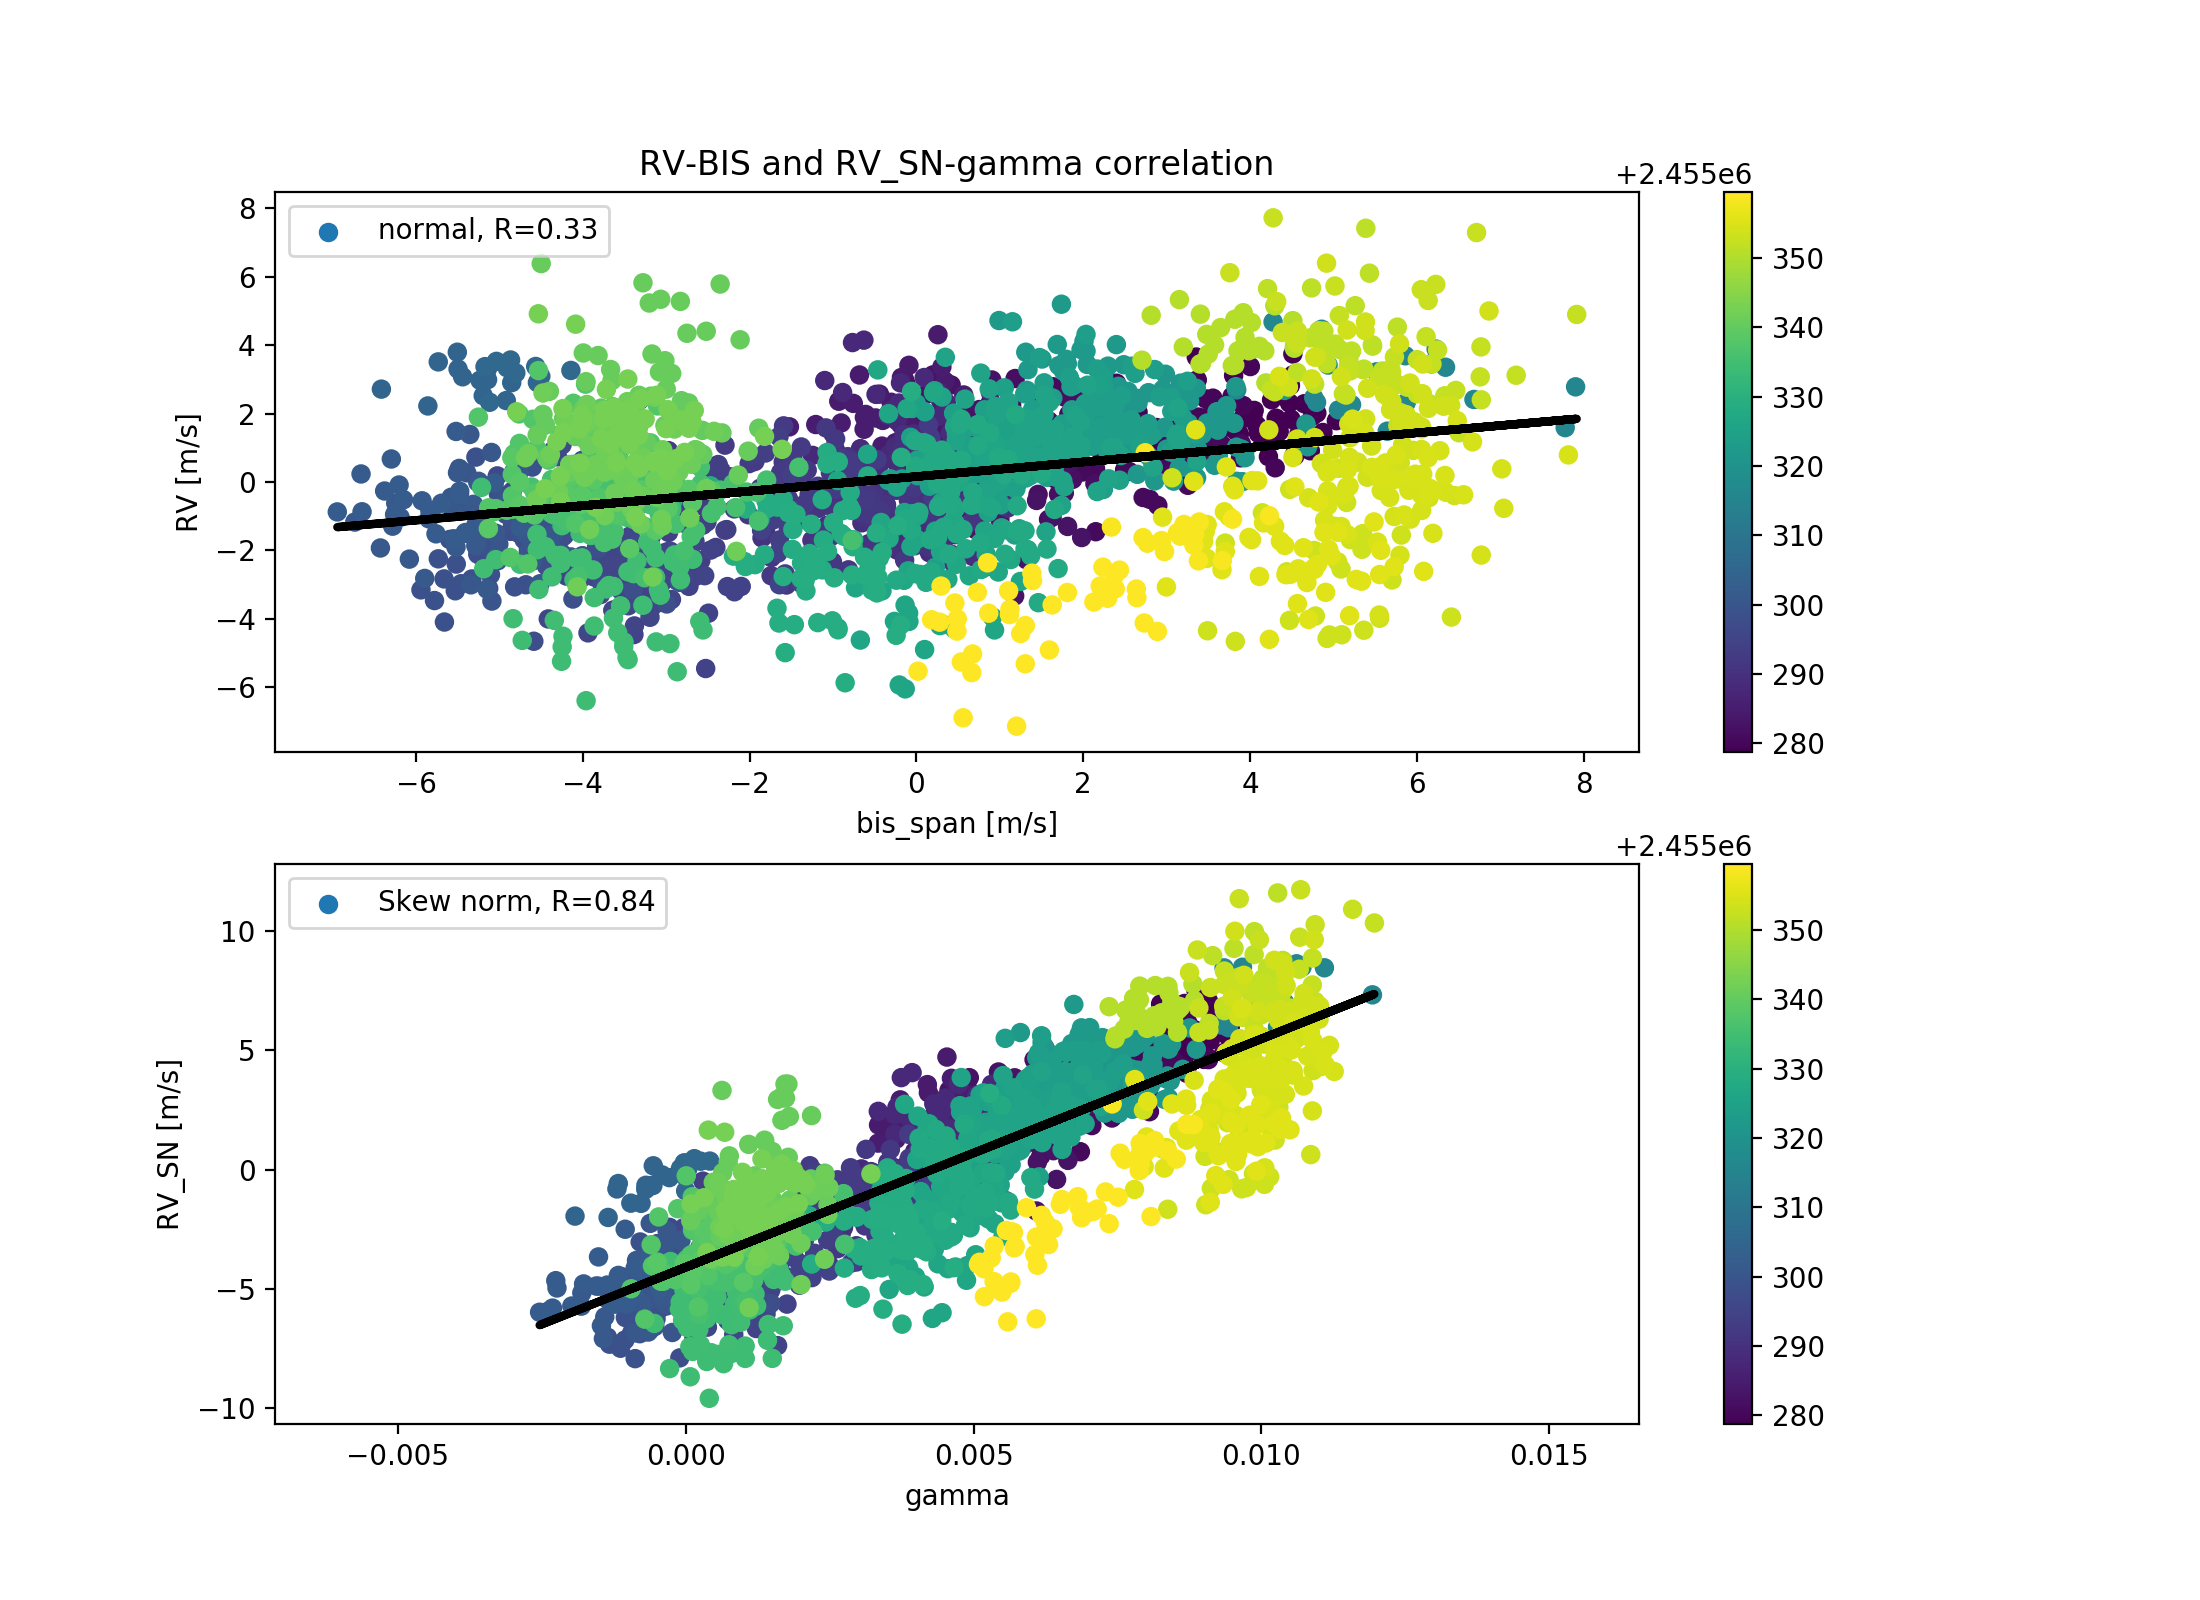

<IPython.core.display.Javascript object>


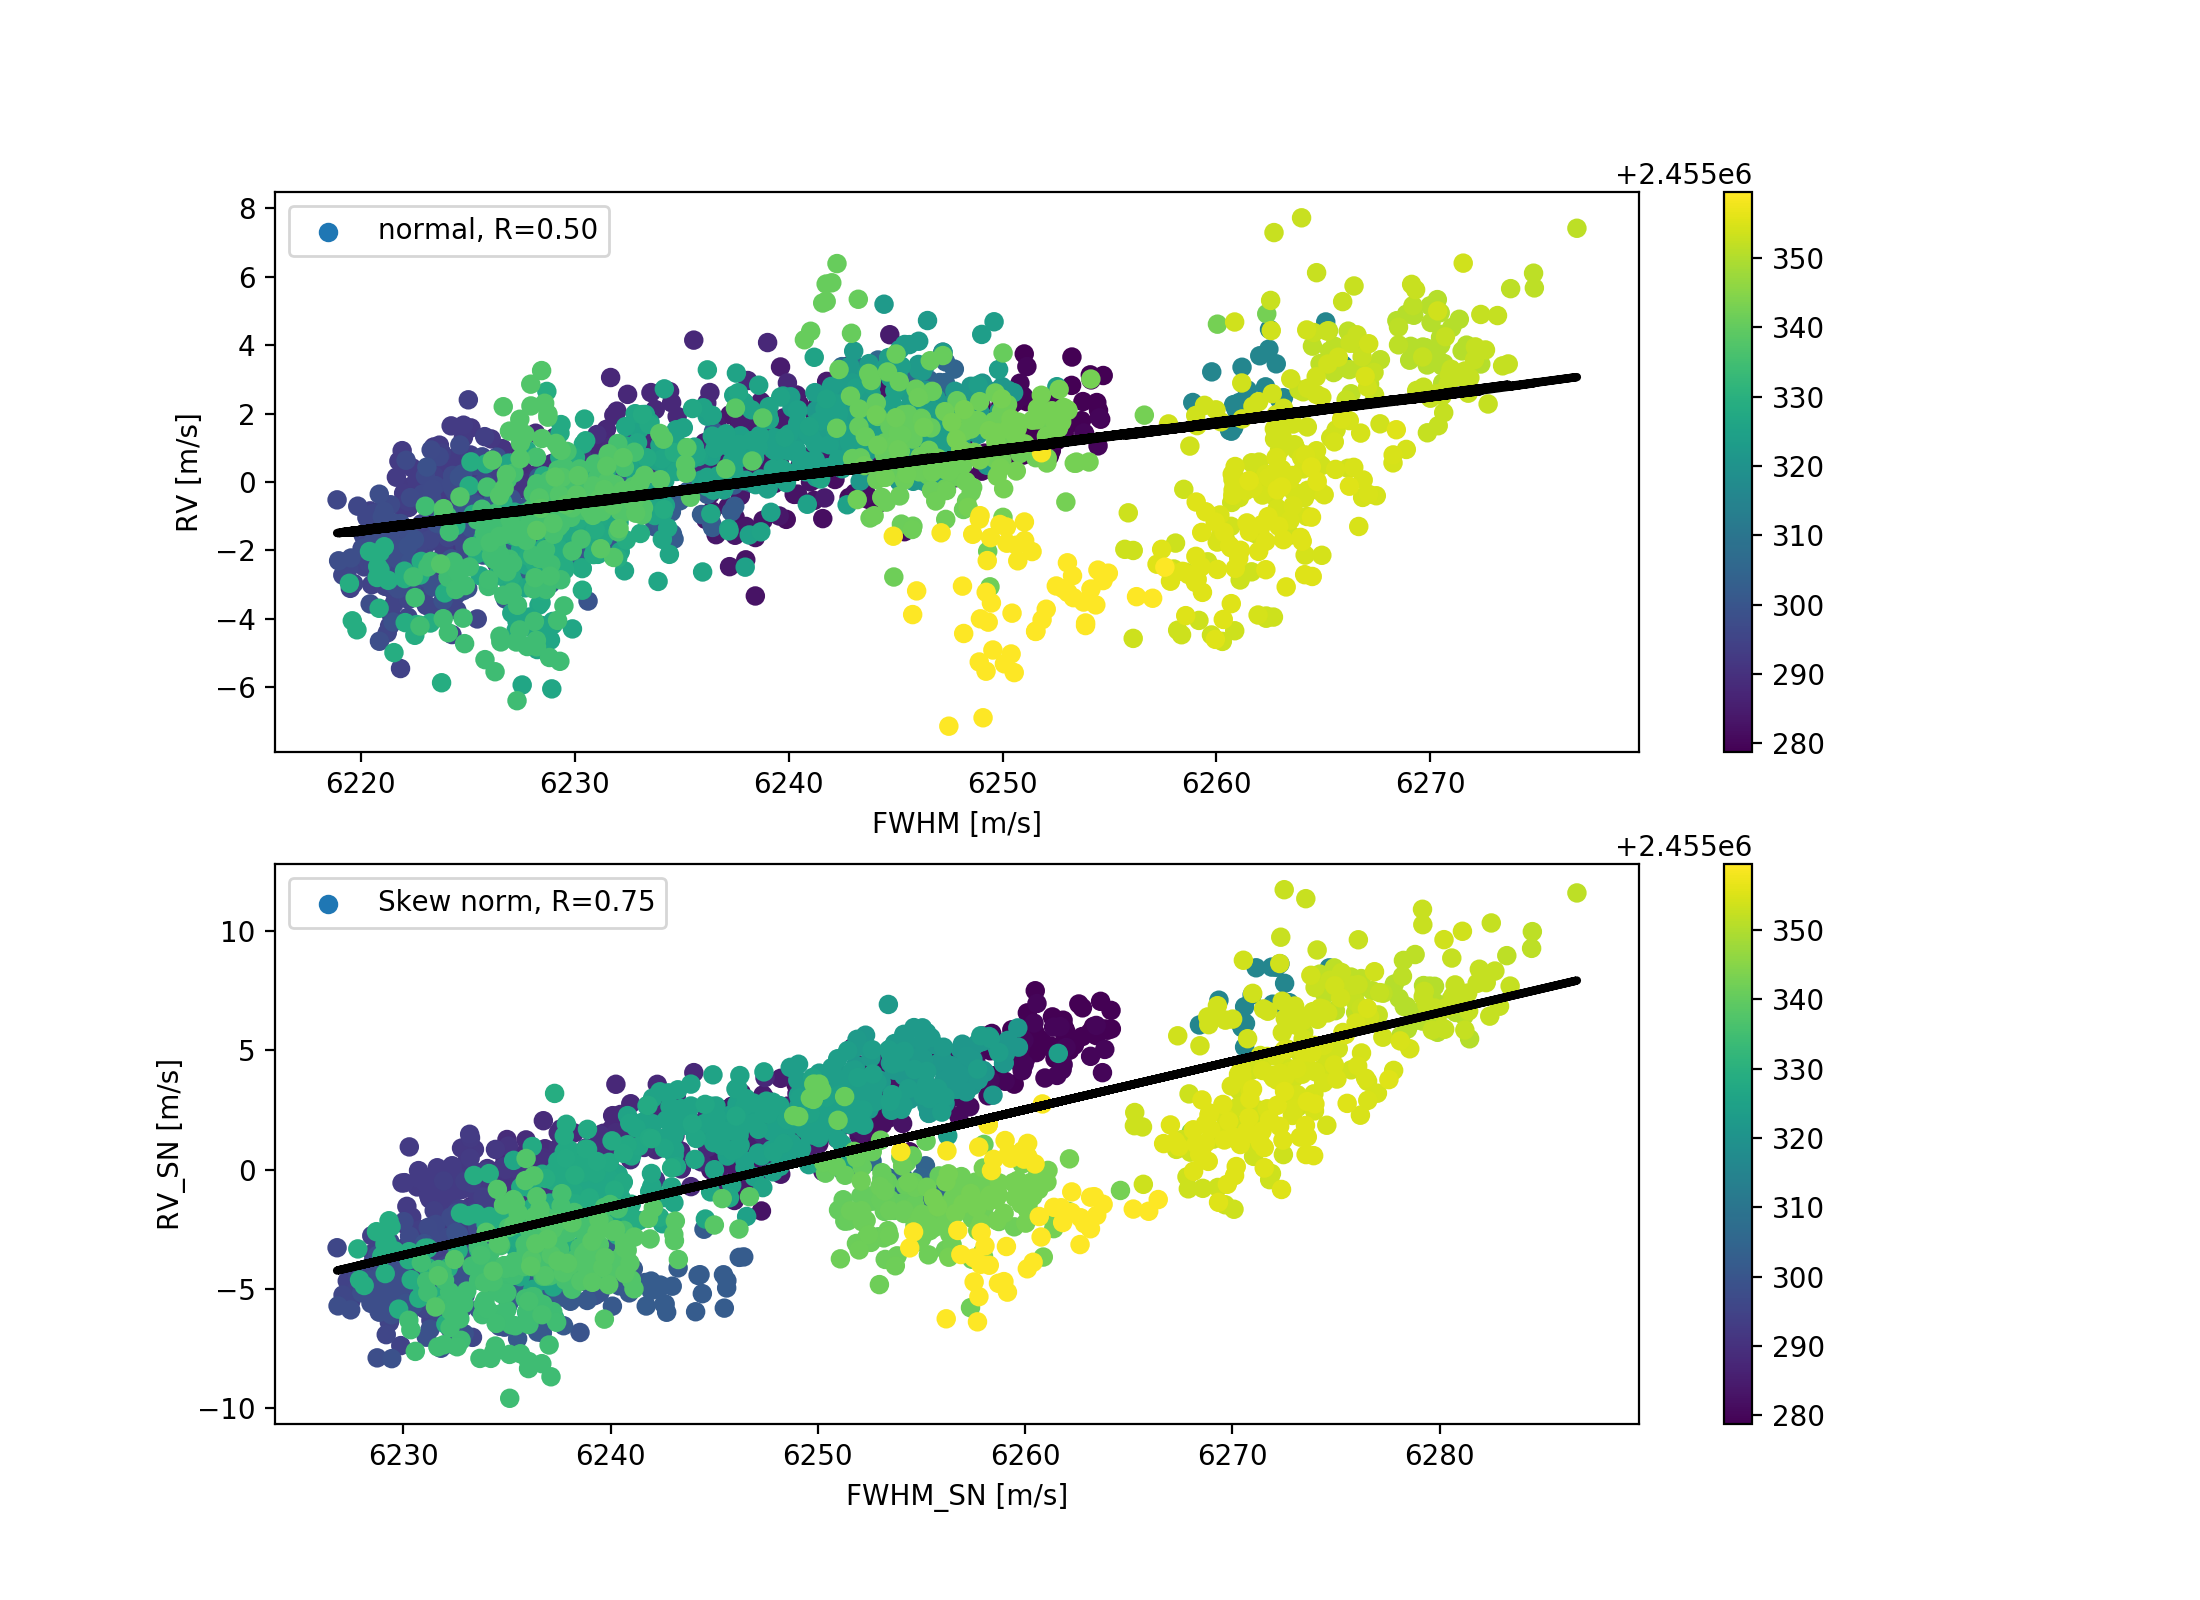

In [7]:
# Fit
fit_bis_span_rv = poly1d(polyfit(bis_span_fit,rv_fit,1))(bis_span_fit)
fit_gamma_mean_skew = poly1d(polyfit(gamma_skew,mean_skew,1))(gamma_skew)

figure()
subplot(211)
title('RV-BIS and RV_SN-gamma correlation')
scatter(bis_span_fit,rv_fit,c=time,label='normal, R=%.2f' % pearsonr(bis_span_fit,rv_fit)[0])
plot(bis_span_fit,fit_bis_span_rv,c='k',lw=3)
ylabel('RV [m/s]')
xlabel('bis_span [m/s]')
legend(loc='best')
colorbar()
subplot(212)
#plot(gamma_skew,mean_skew,'ro',label='Skew norm, R=%.2f' % pearsonr(mean_skew,gamma_skew)[0]zorder=0)
scatter(gamma_skew,mean_skew,c=time,label='Skew norm, R=%.2f' % pearsonr(gamma_skew,mean_skew)[0])
plot(gamma_skew,fit_gamma_mean_skew,c='k',lw=3)
ylabel('RV_SN [m/s]')
xlabel('gamma')
legend(loc='best')
colorbar()

fit_fwhm_rv = poly1d(polyfit(fwhm,rv_fit,1))(fwhm)
fit_sigma_mean_skew = poly1d(polyfit(fwhm_skew,mean_skew,1))(fwhm_skew)

figure()
title('RV-FWHM and RV_SN-FWHM_SN correlation')
subplot(211)
scatter(fwhm_fit,rv_fit,c=time,label='normal, R=%.2f' % pearsonr(fwhm_fit,rv_fit)[0])
plot(fwhm_fit,fit_fwhm_rv,c='k',lw=3)
ylabel('RV [m/s]')
xlabel('FWHM [m/s]')
legend(loc='best')
colorbar()
subplot(212)
scatter(fwhm_skew,mean_skew,c=time,label='Skew norm, R=%.2f' % pearsonr(fwhm_skew,mean_skew)[0])
plot(fwhm_skew,fit_sigma_mean_skew,c='k',lw=3)
ylabel('RV_SN [m/s]')
xlabel('FWHM_SN [m/s]')
legend(loc='best')
colorbar()


<IPython.core.display.Javascript object>


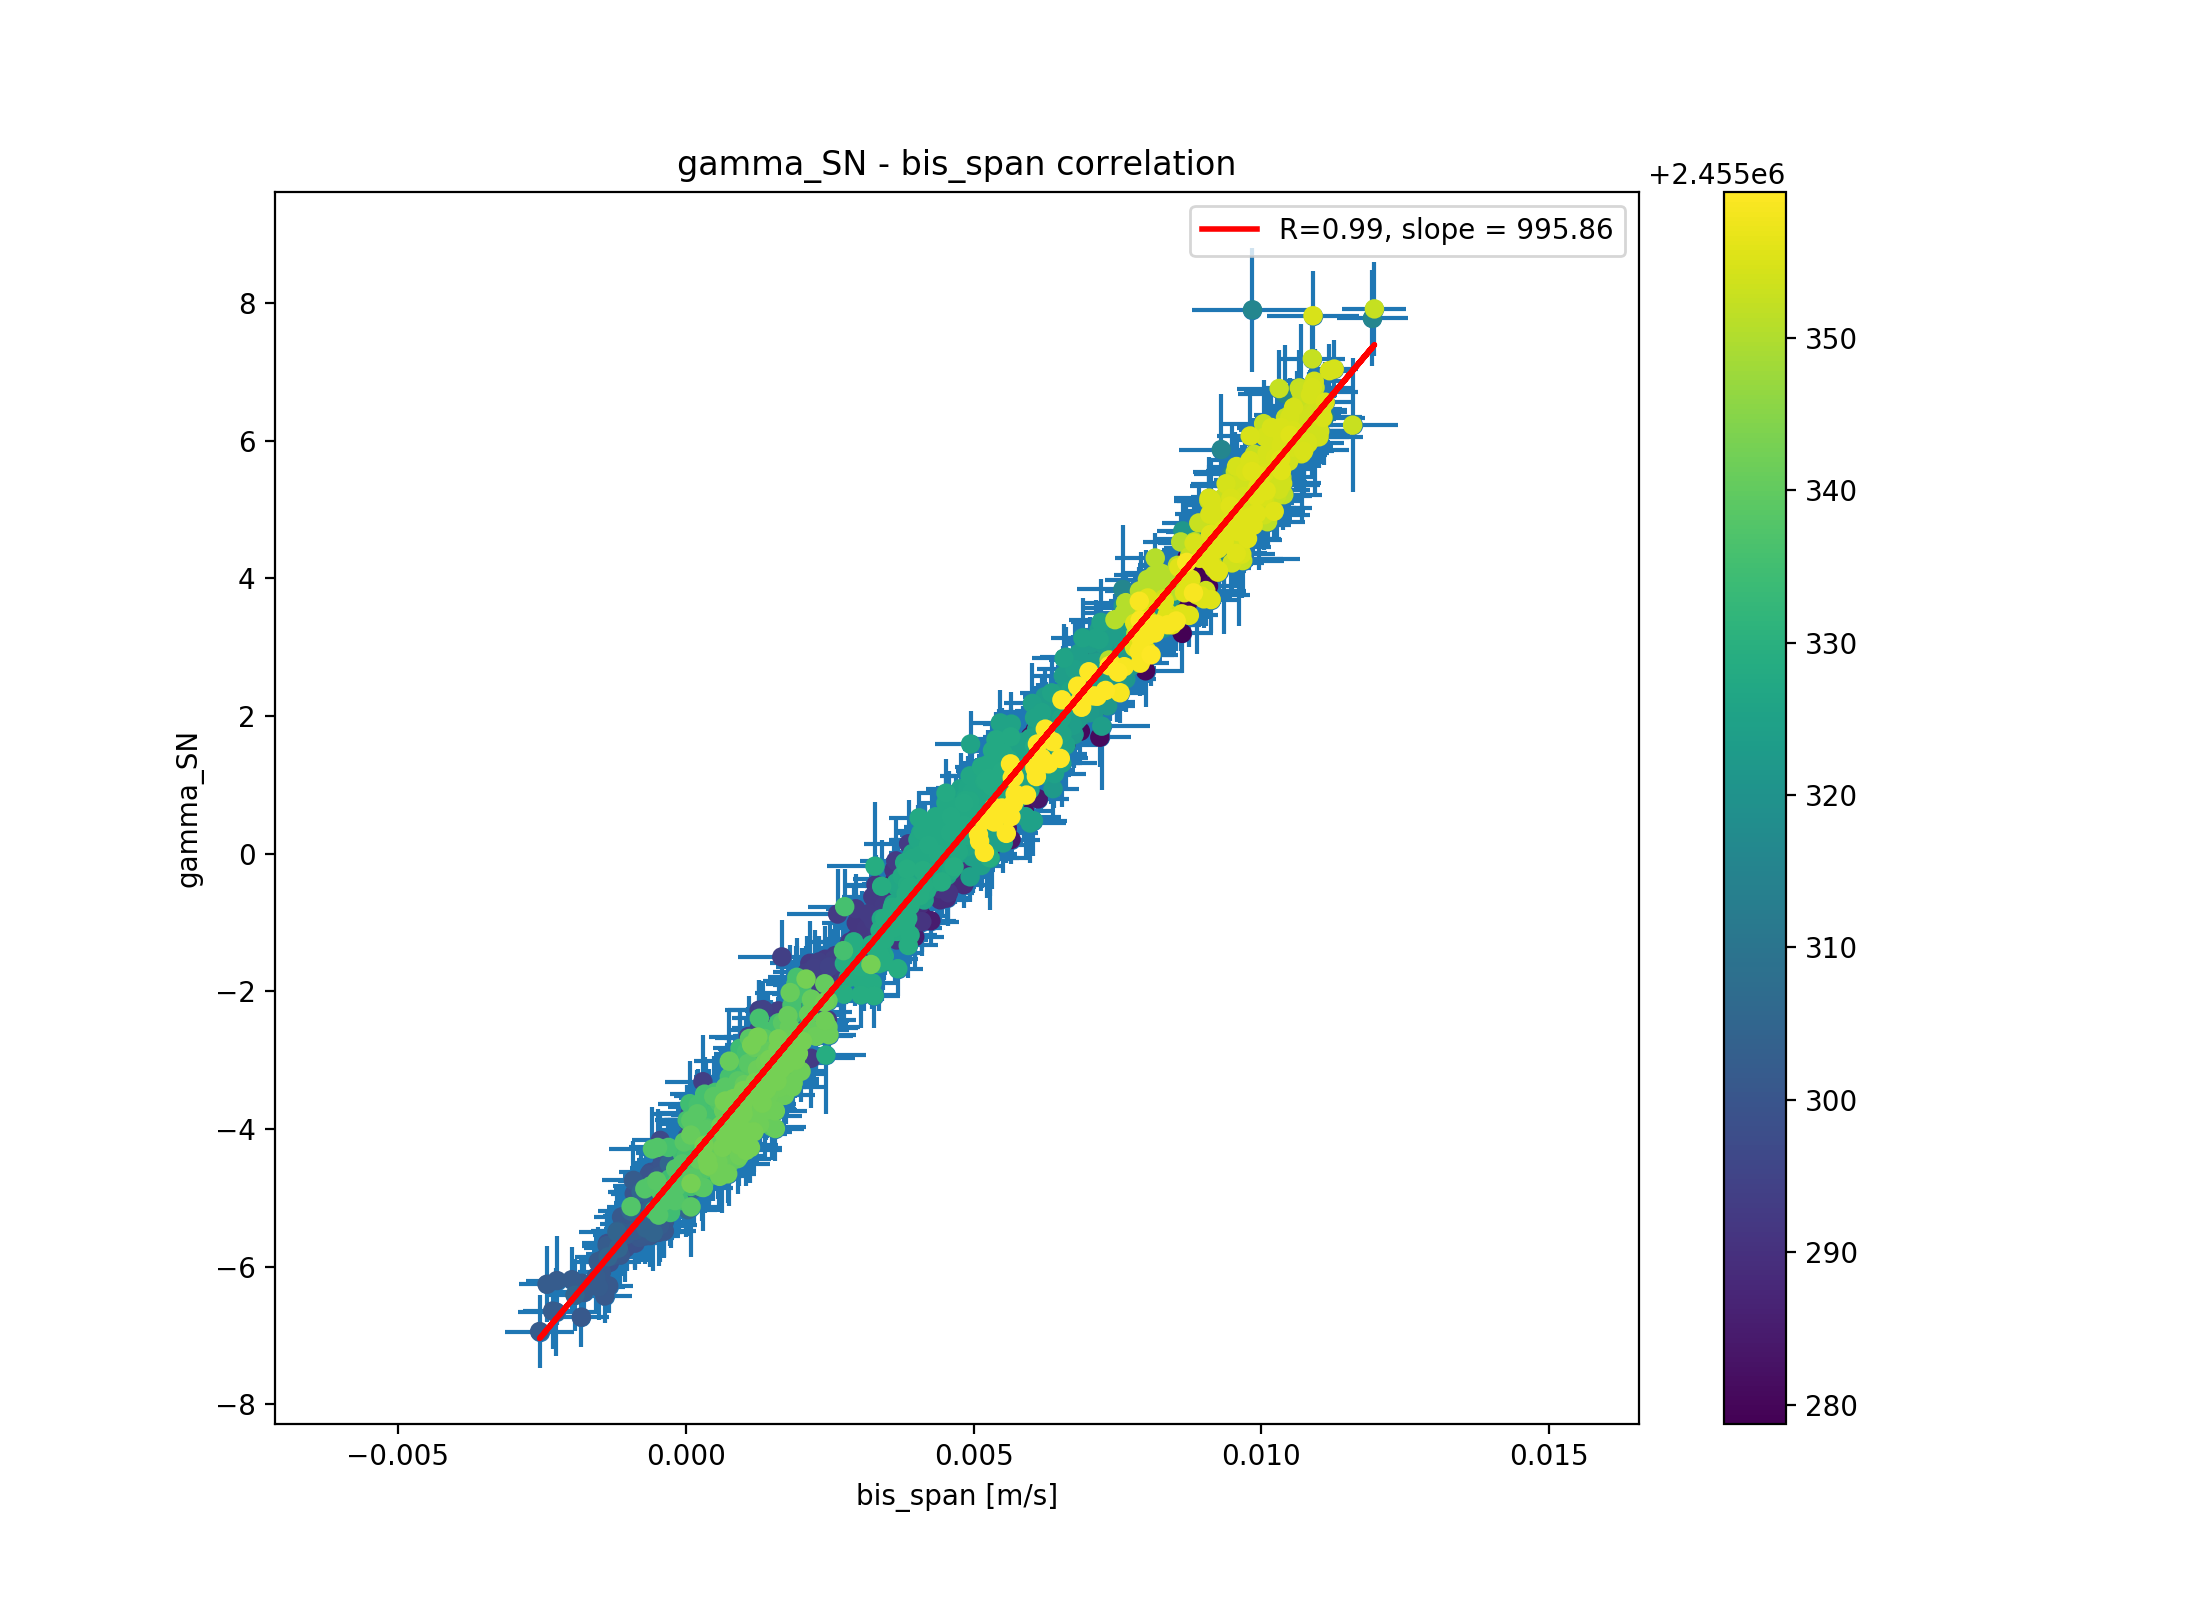

        Not possible to use the error in x because sigma_x > sigma_y in 50% of the case
        Fitting x = c+dy 
        Attention erreur sur y importante pour plus de 20% des points : l'ajustement est peut etre mauvais


In [8]:
figure()
title('gamma_SN - bis_span correlation')
scatter(gamma_skew,bis_span_fit,c=time,zorder=1)
errorbar(gamma_skew,bis_span_fit,xerr=gamma_skew_error,yerr=bis_span_fit_error,marker='o',ls='',zorder=0)
a,b,sigma_a,sigma_b,chi_2,R,good_or_bad_fit = functions.fit_droite_with_weight_2_errors(gamma_skew,bis_span_fit,gamma_skew_error,bis_span_fit_error)
plot(gamma_skew,a+b*gamma_skew,label='R=%.2f, slope = %.2f' % (R,b),color='r',lw=2,zorder=2)
bis_span_gamma_ratio = b
legend(loc='best')
xlabel('bis_span [m/s]')
ylabel('gamma_SN')
colorbar()


In [9]:
Matrice = dstack([bis_span_fit,fwhm_fit,ones(len(bis_span_fit))])
paraN,sig_paraN,modN,chisqN = fit2.linlsq(Matrice[0],rv_fit,rv_fit_error)
Matrice = dstack([gamma_skew,fwhm_skew,ones(len(gamma_skew))])
paraSN,sig_paraSN,modSN,chisqSN = fit2.linlsq(Matrice[0],mean_skew,mean_skew_error)

rv_corr = rv_fit - (paraN[0]*bis_span_fit + paraN[1]*fwhm_fit + paraN[2])
mean_skew_corr = mean_skew - (paraSN[0]*gamma_skew + paraSN[1]*fwhm_skew + paraSN[2])

if star in ['HD128621','HD10700']:
    min_bin,max_bin = functions.binning_prop2(time,1.,1.) # Tous les 8 mois et si pas plus de 2 mois entre 2 measures
else:
    min_bin,max_bin = functions.binning_prop2(time,8.*30,2.*30) # Tous les 8 mois et si pas plus de 2 mois entre 2 measures
time_binned,rv_binned,rv_binned_corr,fwhm_binned,bis_span_binned,fwhm_skew_binned,std_rv_bin,std_mean_skew_bin,std_rv_bin_corr,std_mean_skew_bin_corr,std_fwhm_bin,std_bis_span_bin,std_fwhm_skew_bin,std_gamma_bin = [],[],[],[],[],[],[],[],[],[],[],[],[],[]
for i,(x,y) in enumerate(zip(min_bin,max_bin)):
    W = sum(1./noise[x:y]**2)
    w = 1./W * 1./noise[x:y]**2
    time_binned = append(time_binned,stats.wmean(time[x:y],w))
    rv_binned = append(rv_binned,stats.wmean(rv_fit[x:y],w))
    rv_binned_corr = append(rv_binned_corr,stats.wmean(rv_corr[x:y],w))
    fwhm_binned = append(fwhm_binned,stats.wmean(fwhm_fit[x:y],w))
    std_fwhm_bin = append(std_fwhm_bin,std(fwhm_fit[x:y]))
    bis_span_binned = append(bis_span_binned,stats.wmean(bis_span_fit[x:y],w))
    std_bis_span_bin = append(std_bis_span_bin,std(bis_span_fit[x:y]))
    fwhm_skew_binned = append(fwhm_skew_binned,stats.wmean(fwhm_skew[x:y],w))
    std_fwhm_skew_bin = append(std_fwhm_skew_bin,std(fwhm_skew[x:y]))
    std_gamma_bin = append(std_gamma_bin,std(gamma_skew[x:y]))
    std_rv_bin = append(std_rv_bin,std(rv_fit[x:y]))
    std_mean_skew_bin = append(std_mean_skew_bin,std(mean_skew[x:y]))
    std_rv_bin_corr = append(std_rv_bin_corr,std((rv_corr)[x:y]))
    std_mean_skew_bin_corr = append(std_mean_skew_bin_corr,std(mean_skew_corr[x:y]))


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.


<IPython.core.display.Javascript object>


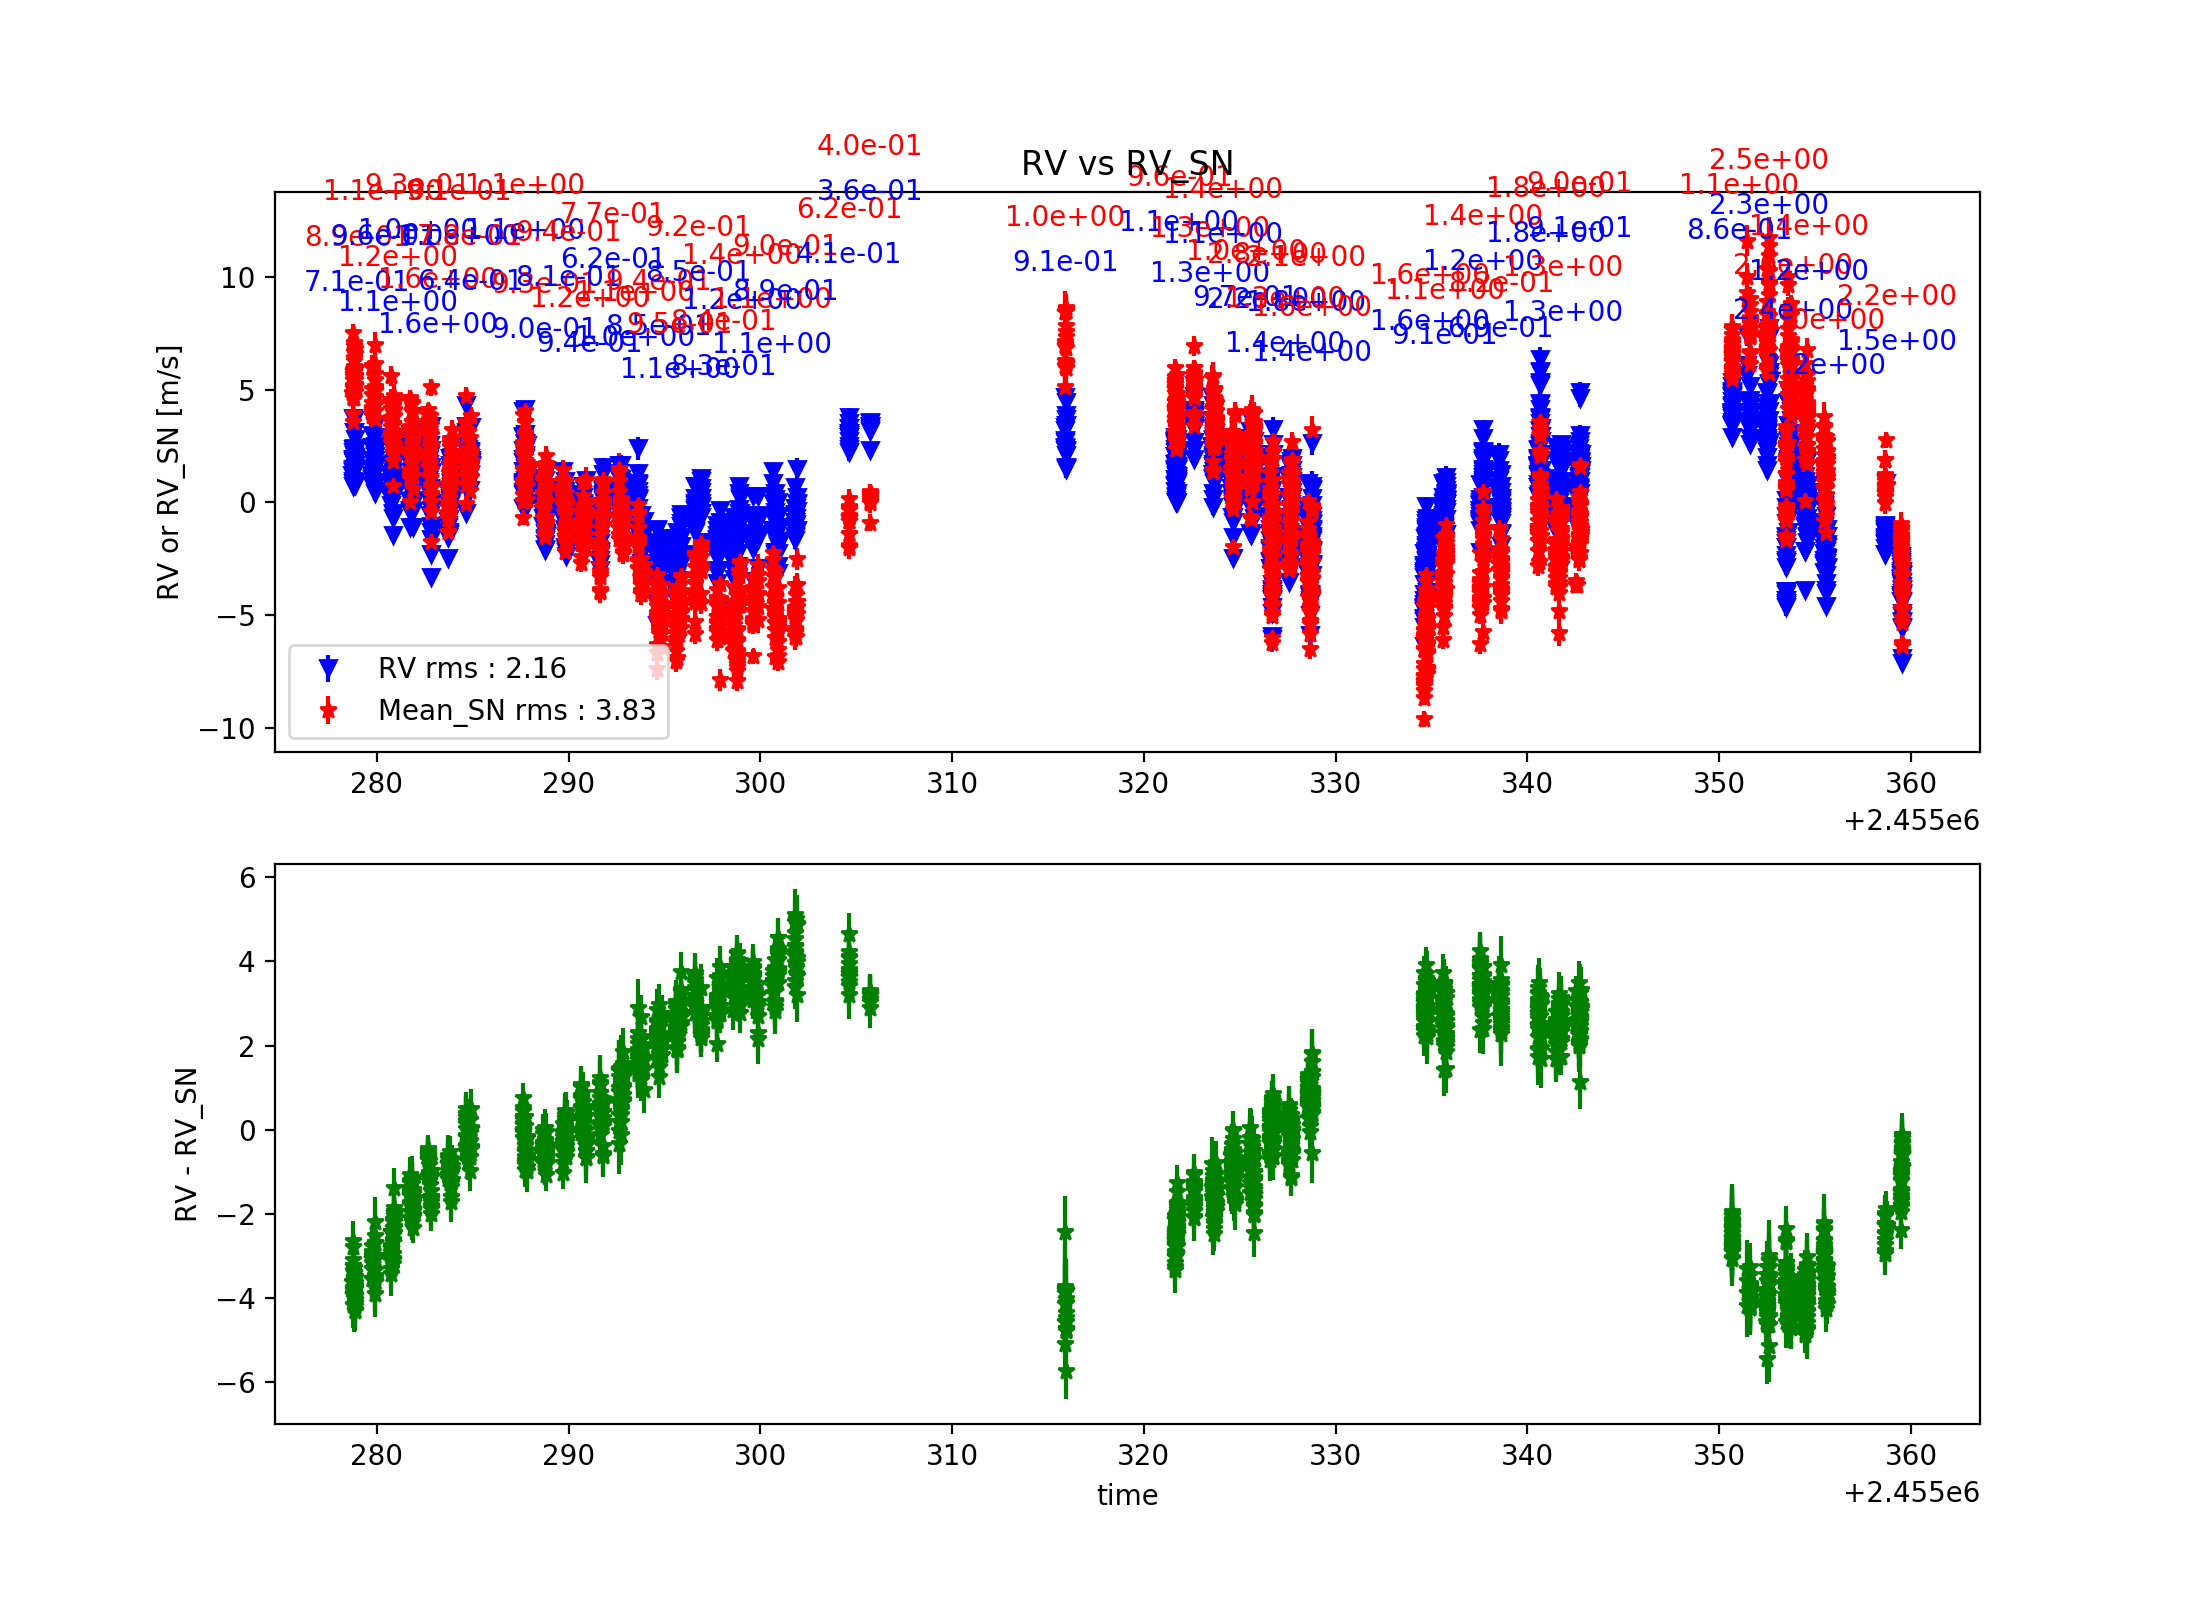

<IPython.core.display.Javascript object>


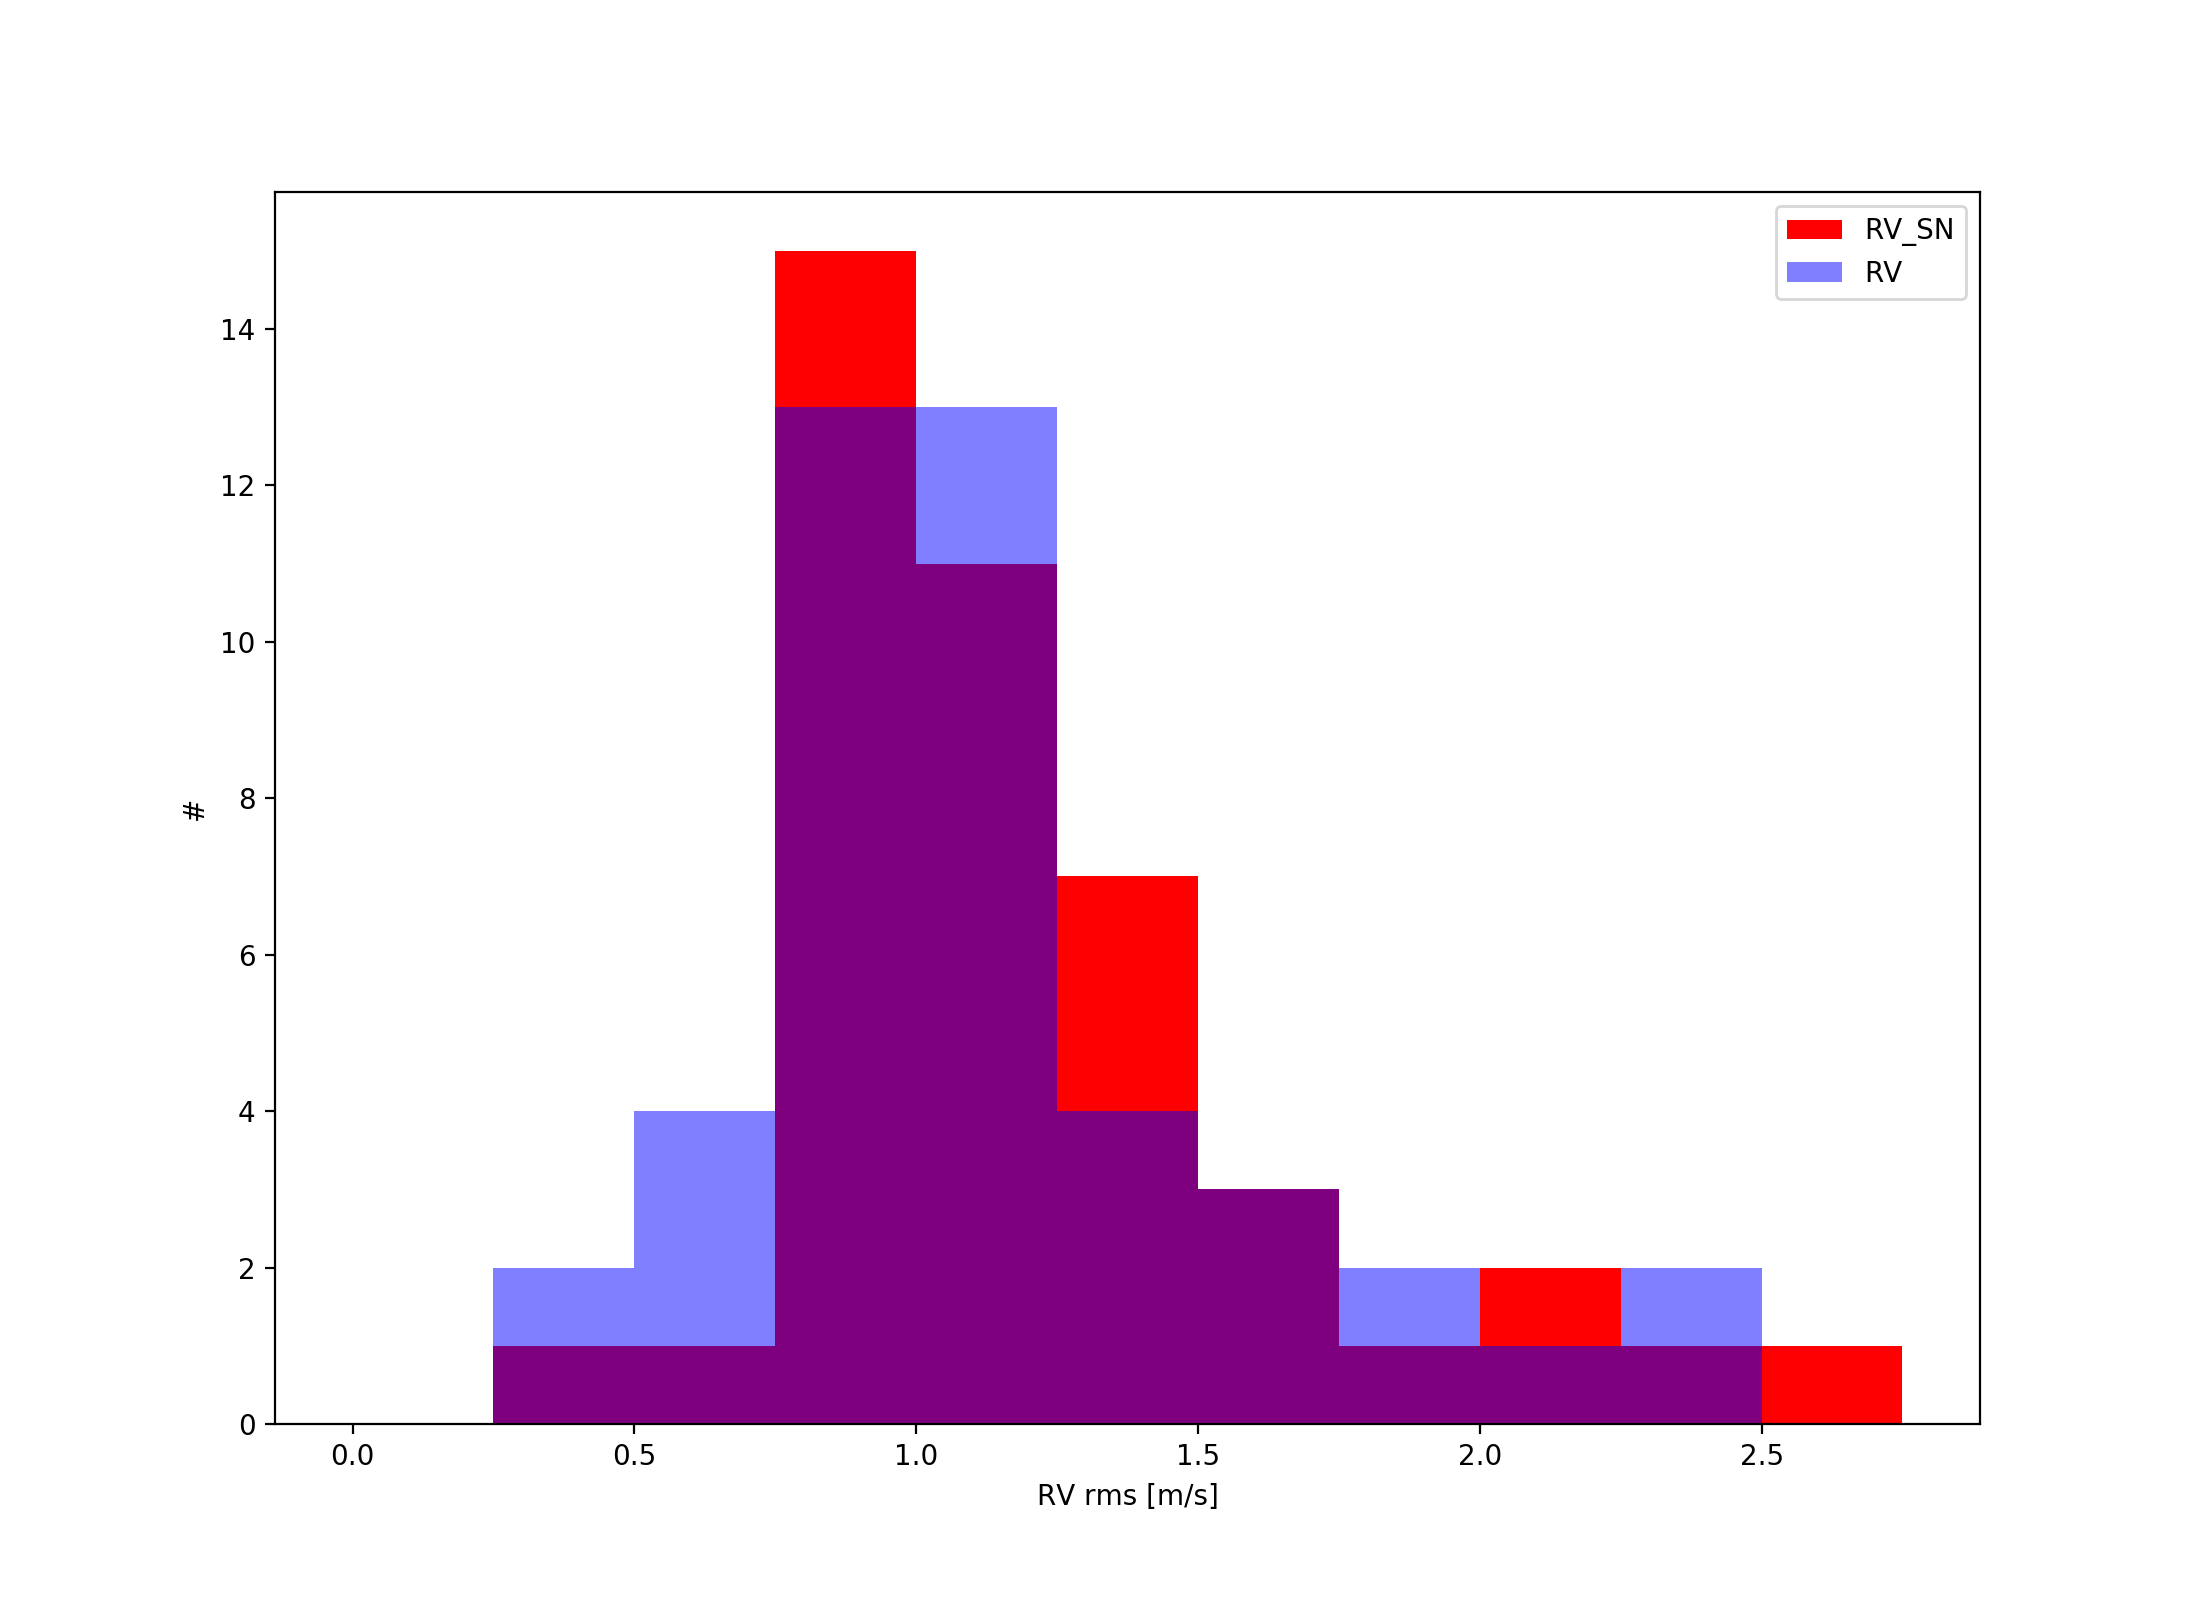

In [10]:
figure()
subplot(211)
title('RV vs RV_SN')
errorbar(time,rv_fit,RV_precision_ccf2,c='b',marker='v',ls='',label = 'RV rms : %.2f' % std(rv_fit))
errorbar(time,mean_skew,mean_skew_error,c='r',marker='*',ls='',label = 'Mean_SN rms : %.2f' % std(mean_skew))
for i,(time_bin,rv_bin,std_rv,std_mean_skew) in enumerate(zip(time_binned,rv_binned,std_rv_bin,std_mean_skew_bin)):
    text(time_bin,rv_bin+8+i%2*2.5,'%.1e' % (std_rv),color='b',va='center',ha='center')
    text(time_bin,rv_bin+10+i%2*2.5,'%.1e' % (std_mean_skew),color='r',va='center',ha='center')
if len(bad_points) > 0:
    plot(time[bad_points],mean_skew[bad_points],marker='o',color='g',ls='')
legend(loc=3)
ylabel('RV or RV_SN [m/s]')
ax = gca()
subplot(212,sharex=ax)
errorbar(time,rv_fit-mean_skew,sqrt(rv_fit_error**2 + mean_skew_error**2),color='g',marker='*',ls='')
ylabel('RV - RV_SN')
xlabel('time')

figure()
bins_vect = arange(0,3,0.25)
hist(std_mean_skew_bin,bins=bins_vect,color='r',label='RV_SN')
hist(std_rv_bin,bins=bins_vect,color='b',alpha=0.5,label='RV')
legend(loc='best')
xlabel('RV rms [m/s]')
ylabel('#')


<IPython.core.display.Javascript object>


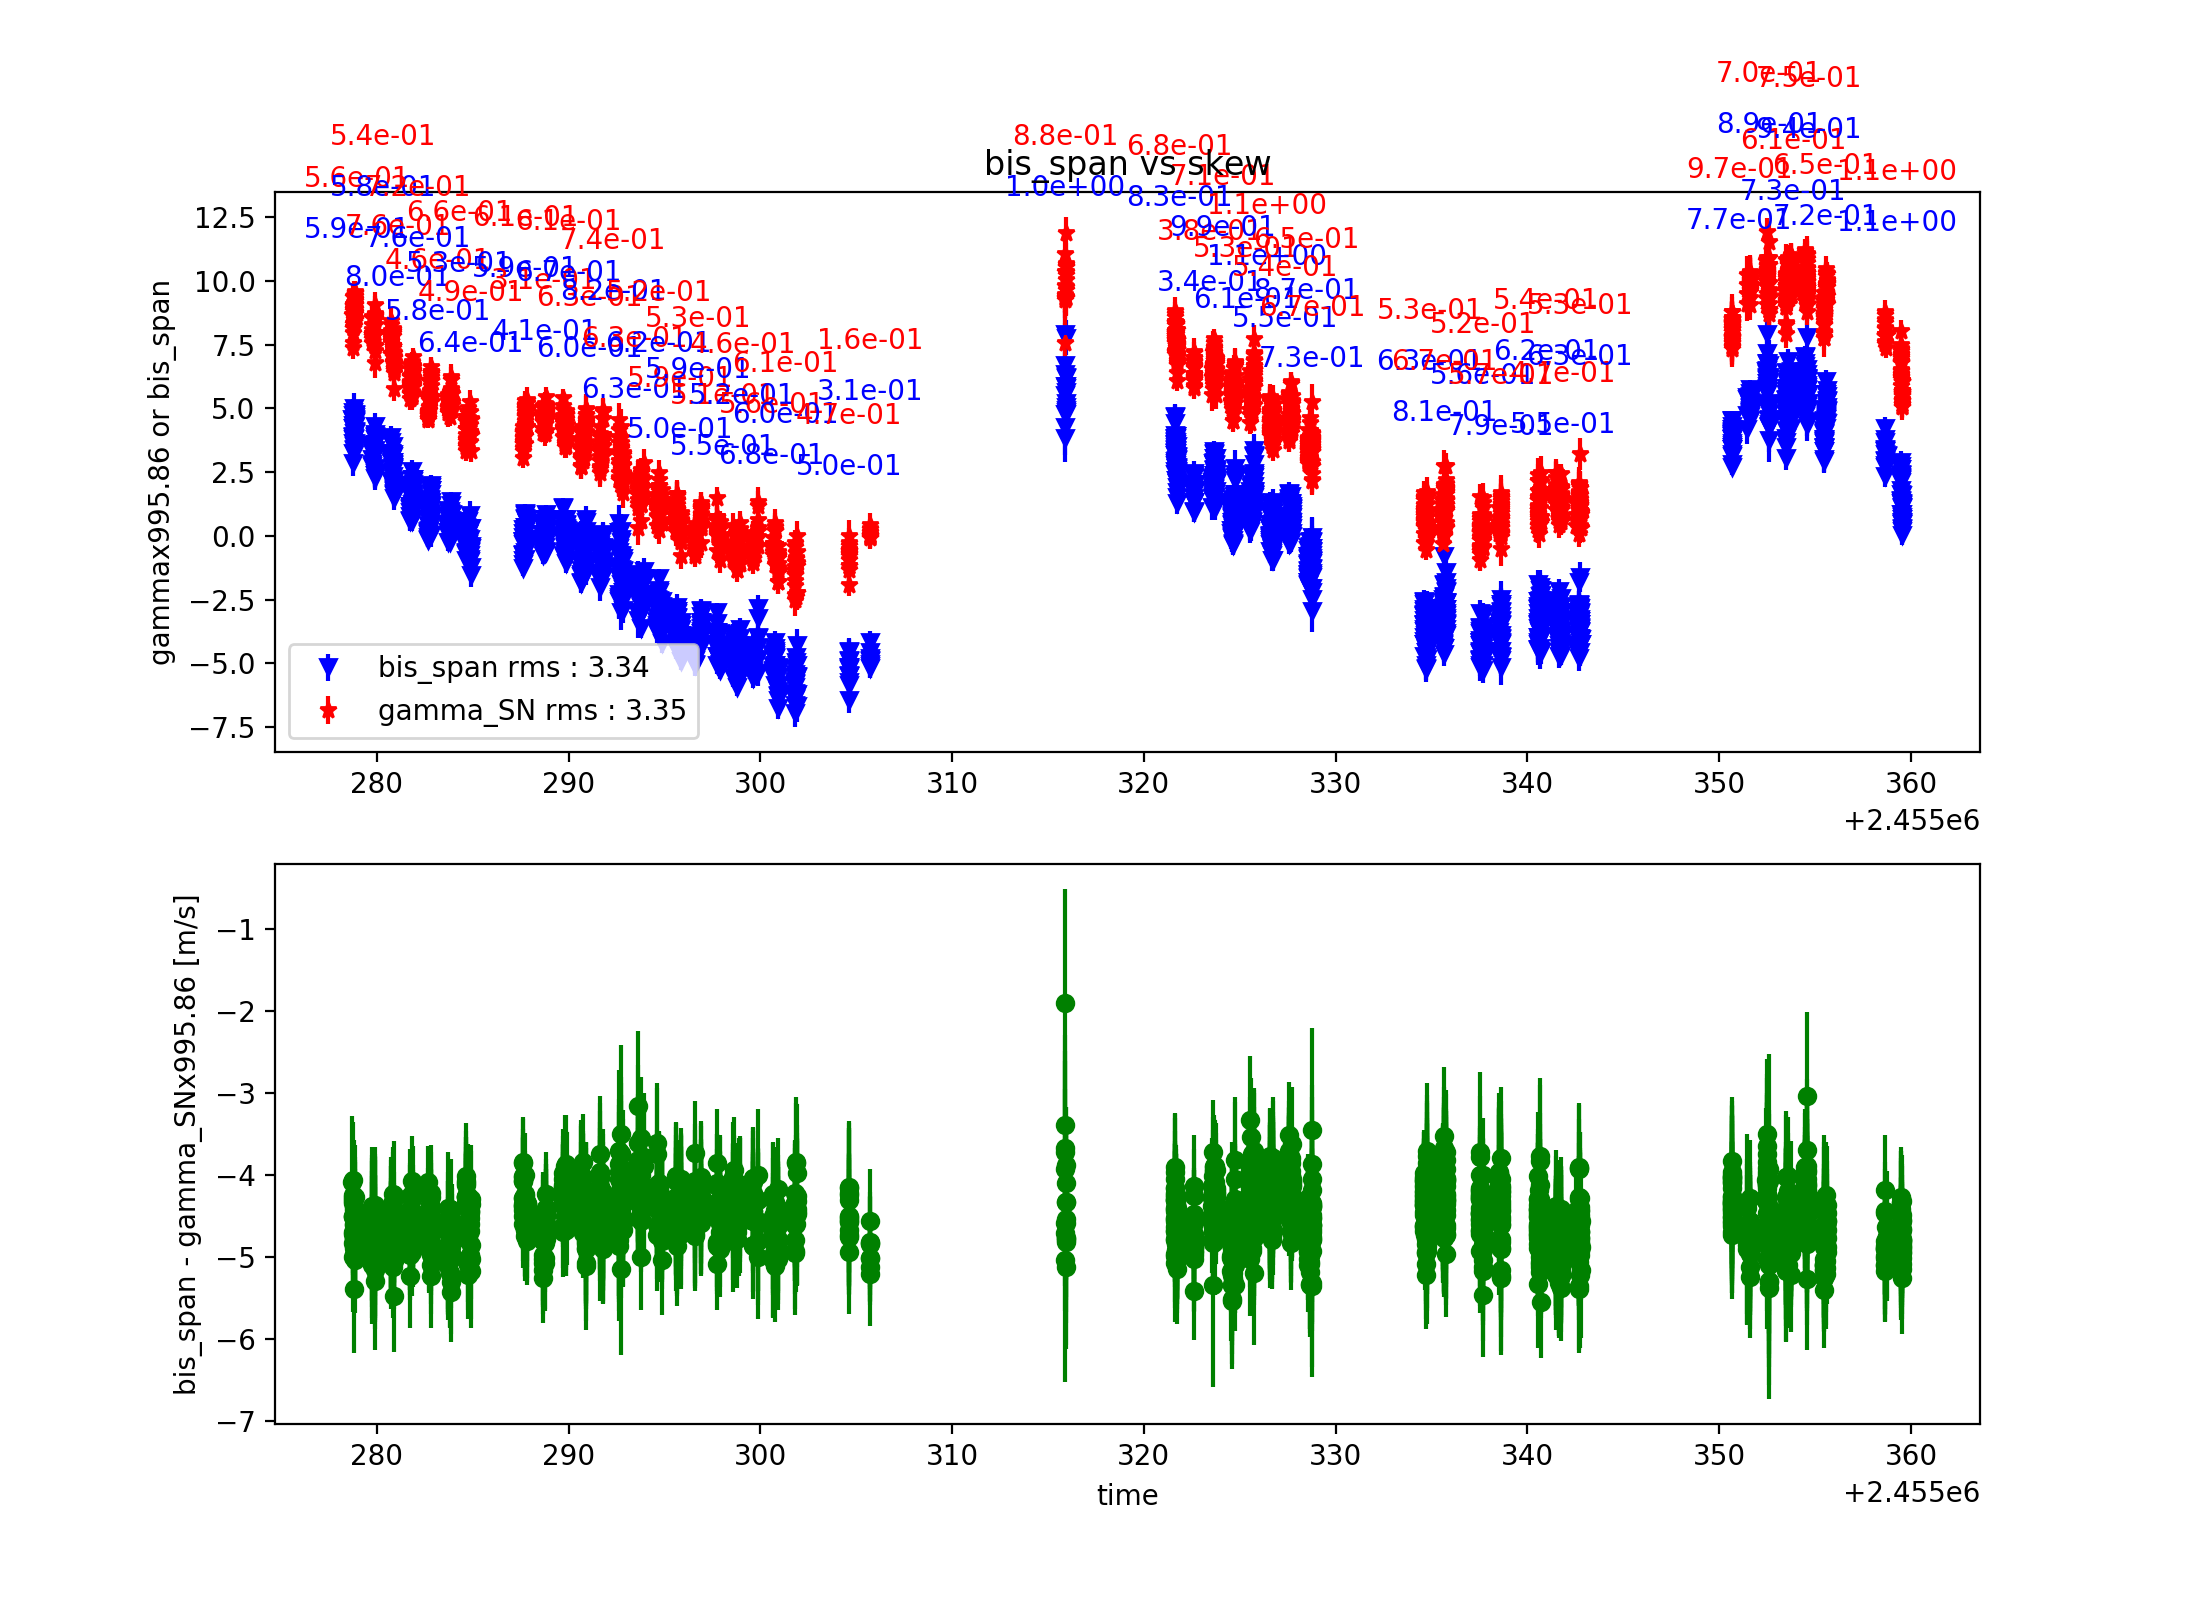

<IPython.core.display.Javascript object>


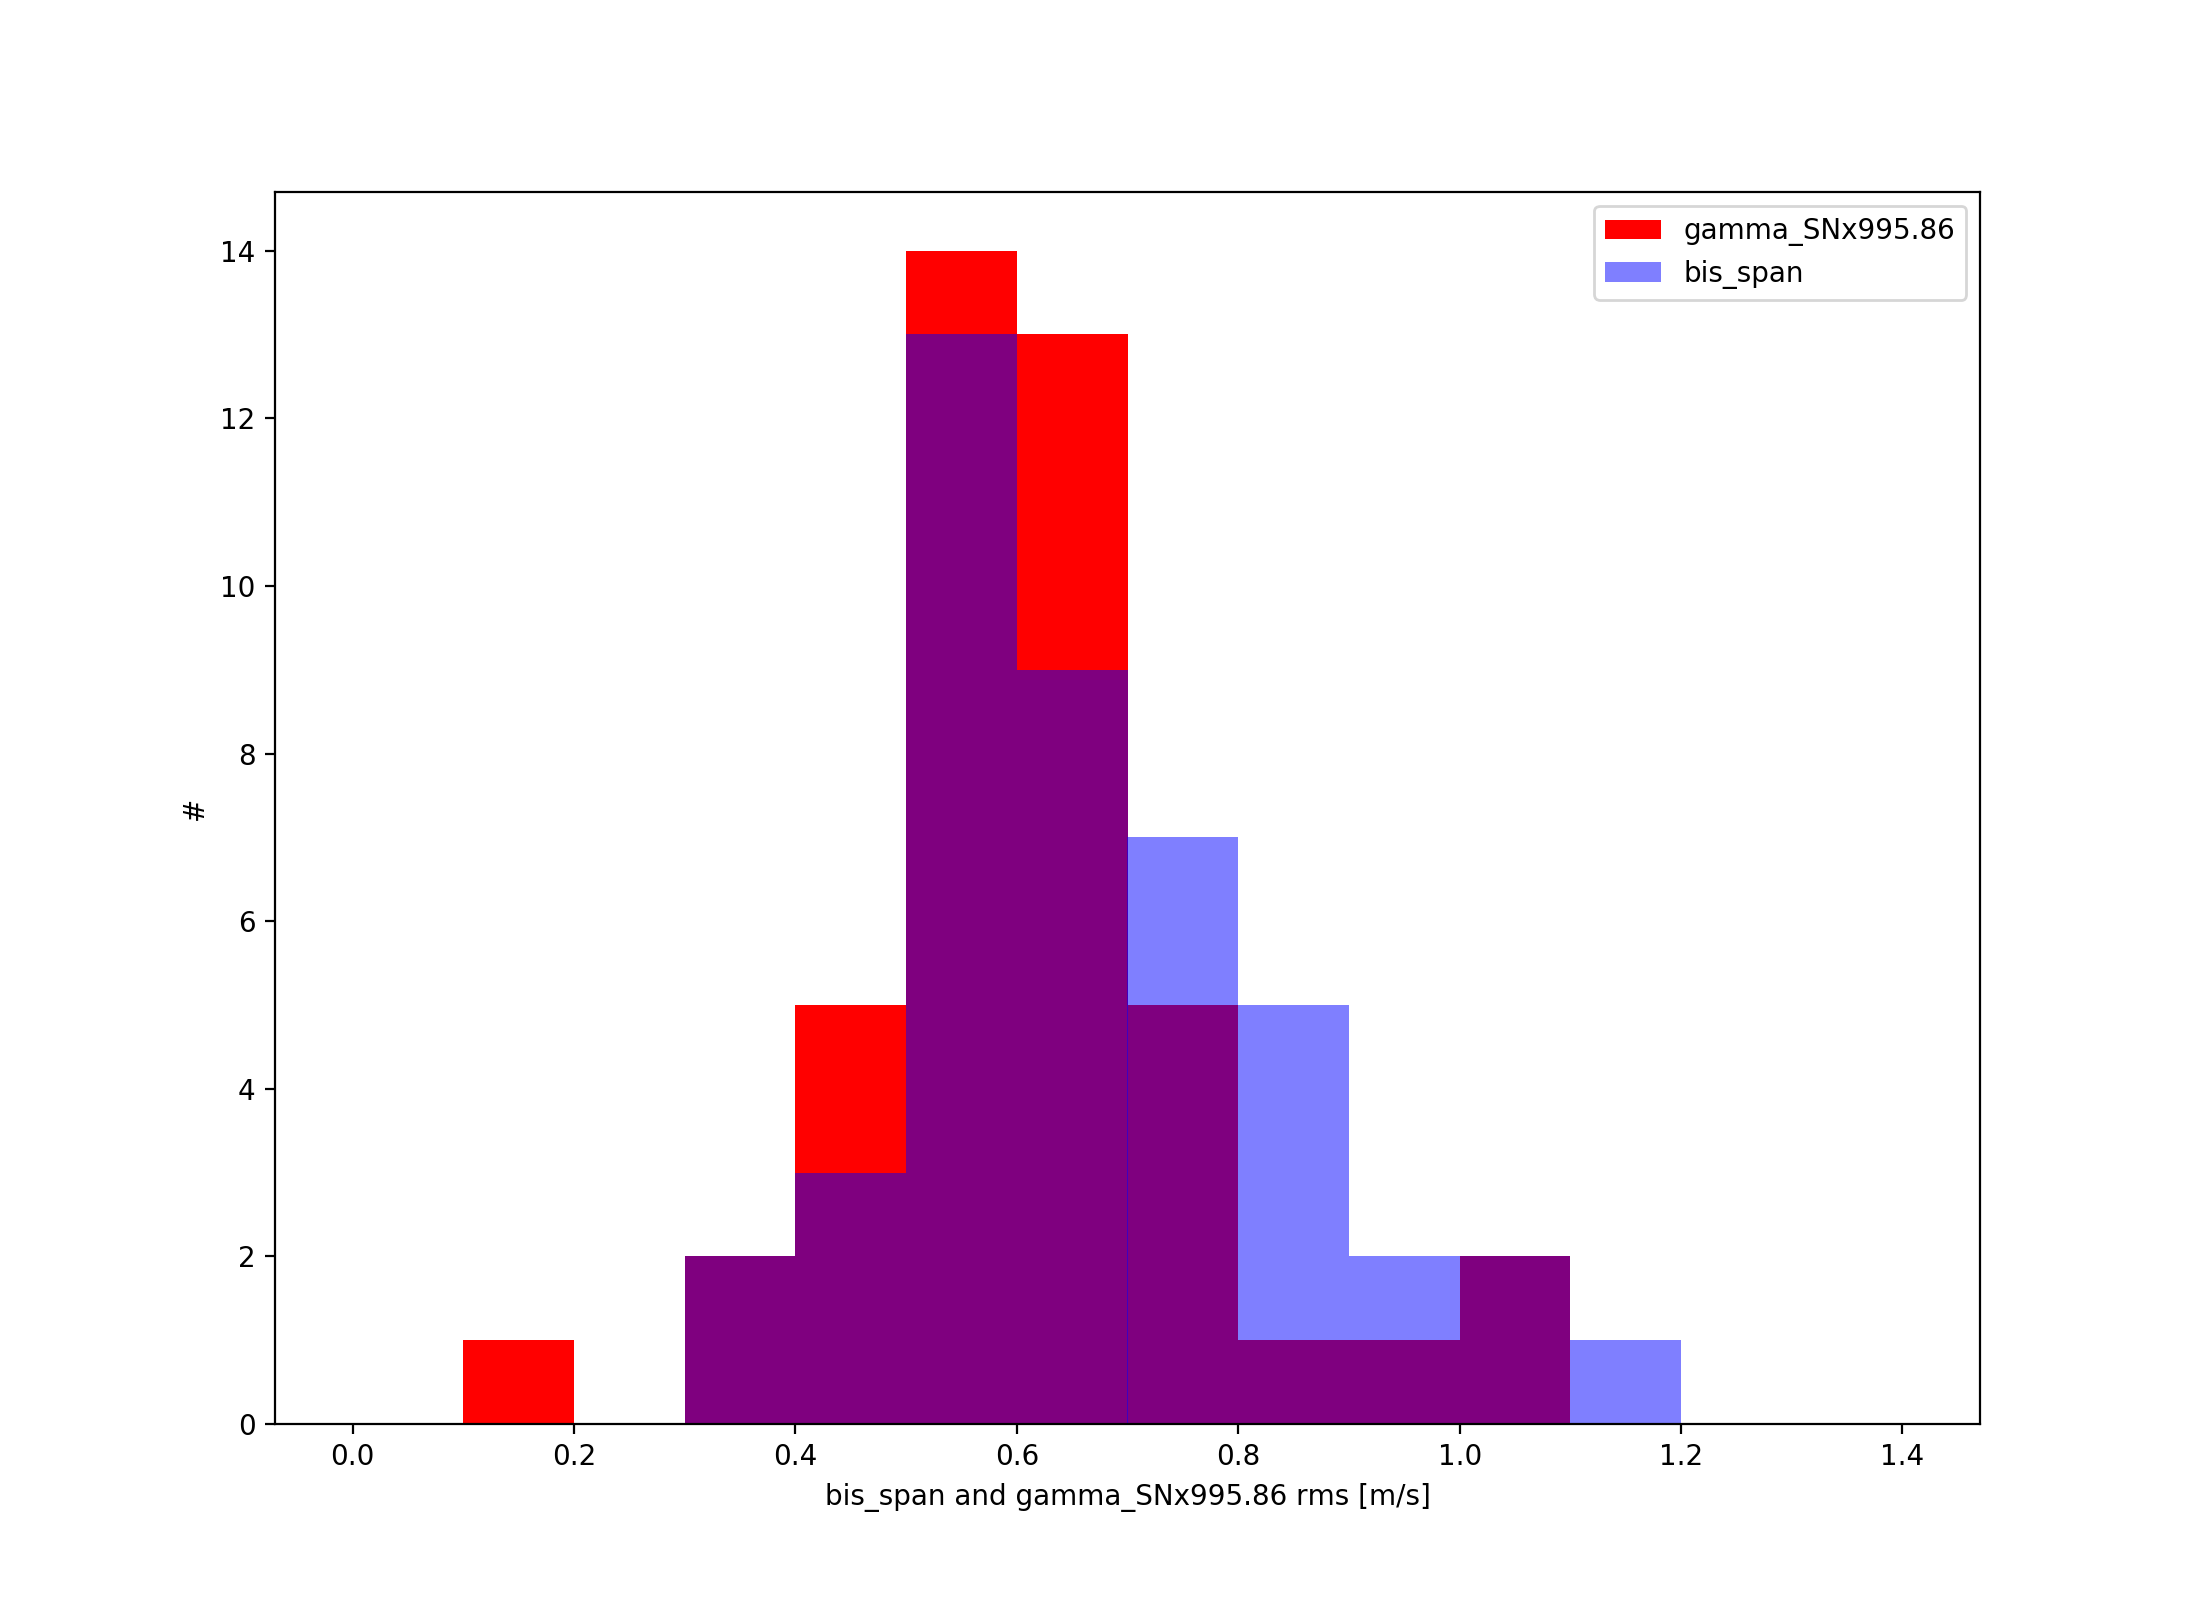

In [11]:
figure()
subplot(211)
title('bis_span vs skew')
errorbar(time[:len(gamma_skew)],bis_span_fit,bis_span_fit_error,c='b',marker='v',ls='',label = 'bis_span rms : %.2f' % std(bis_span_fit))
errorbar(time[:len(gamma_skew)],gamma_skew*bis_span_gamma_ratio,gamma_skew_error*bis_span_gamma_ratio,c='r',marker='*',ls='',label = 'gamma_SN rms : %.2f' % std(gamma_skew*bis_span_gamma_ratio))
for i,(time_bin,bis_span_bin,std_bis_span,std_gamma) in enumerate(zip(time_binned,bis_span_binned,std_bis_span_bin,std_gamma_bin*bis_span_gamma_ratio)):
    text(time_bin,bis_span_bin+8+i%2*2.5,'%.1e' % (std_bis_span),color='b',va='center',ha='center')
    text(time_bin,bis_span_bin+10+i%2*2.5,'%.1e' % (std_gamma),color='r',va='center',ha='center')
ylabel('gammax%.2f or bis_span' % bis_span_gamma_ratio)
legend(loc=3)
ax=gca()
subplot(212,sharex=ax)
errorbar(time,bis_span_fit-gamma_skew*bis_span_gamma_ratio,sqrt((bis_span_fit_error)**2 + (gamma_skew_error*bis_span_gamma_ratio)**2),color='g',marker='o',ls='')
ylabel('bis_span - gamma_SNx%.2f [m/s]'% bis_span_gamma_ratio)
xlabel('time')

figure()
bins_vect = arange(0,1.5,0.1)
hist(std_gamma_bin*bis_span_gamma_ratio,bins=bins_vect,color='r',label='gamma_SNx%.2f'% bis_span_gamma_ratio)
hist(std_bis_span_bin,bins=bins_vect,color='b',alpha=0.5,label='bis_span')
legend(loc='best')
xlabel('bis_span and gamma_SNx%.2f rms [m/s]'% bis_span_gamma_ratio)
ylabel('#')


<IPython.core.display.Javascript object>


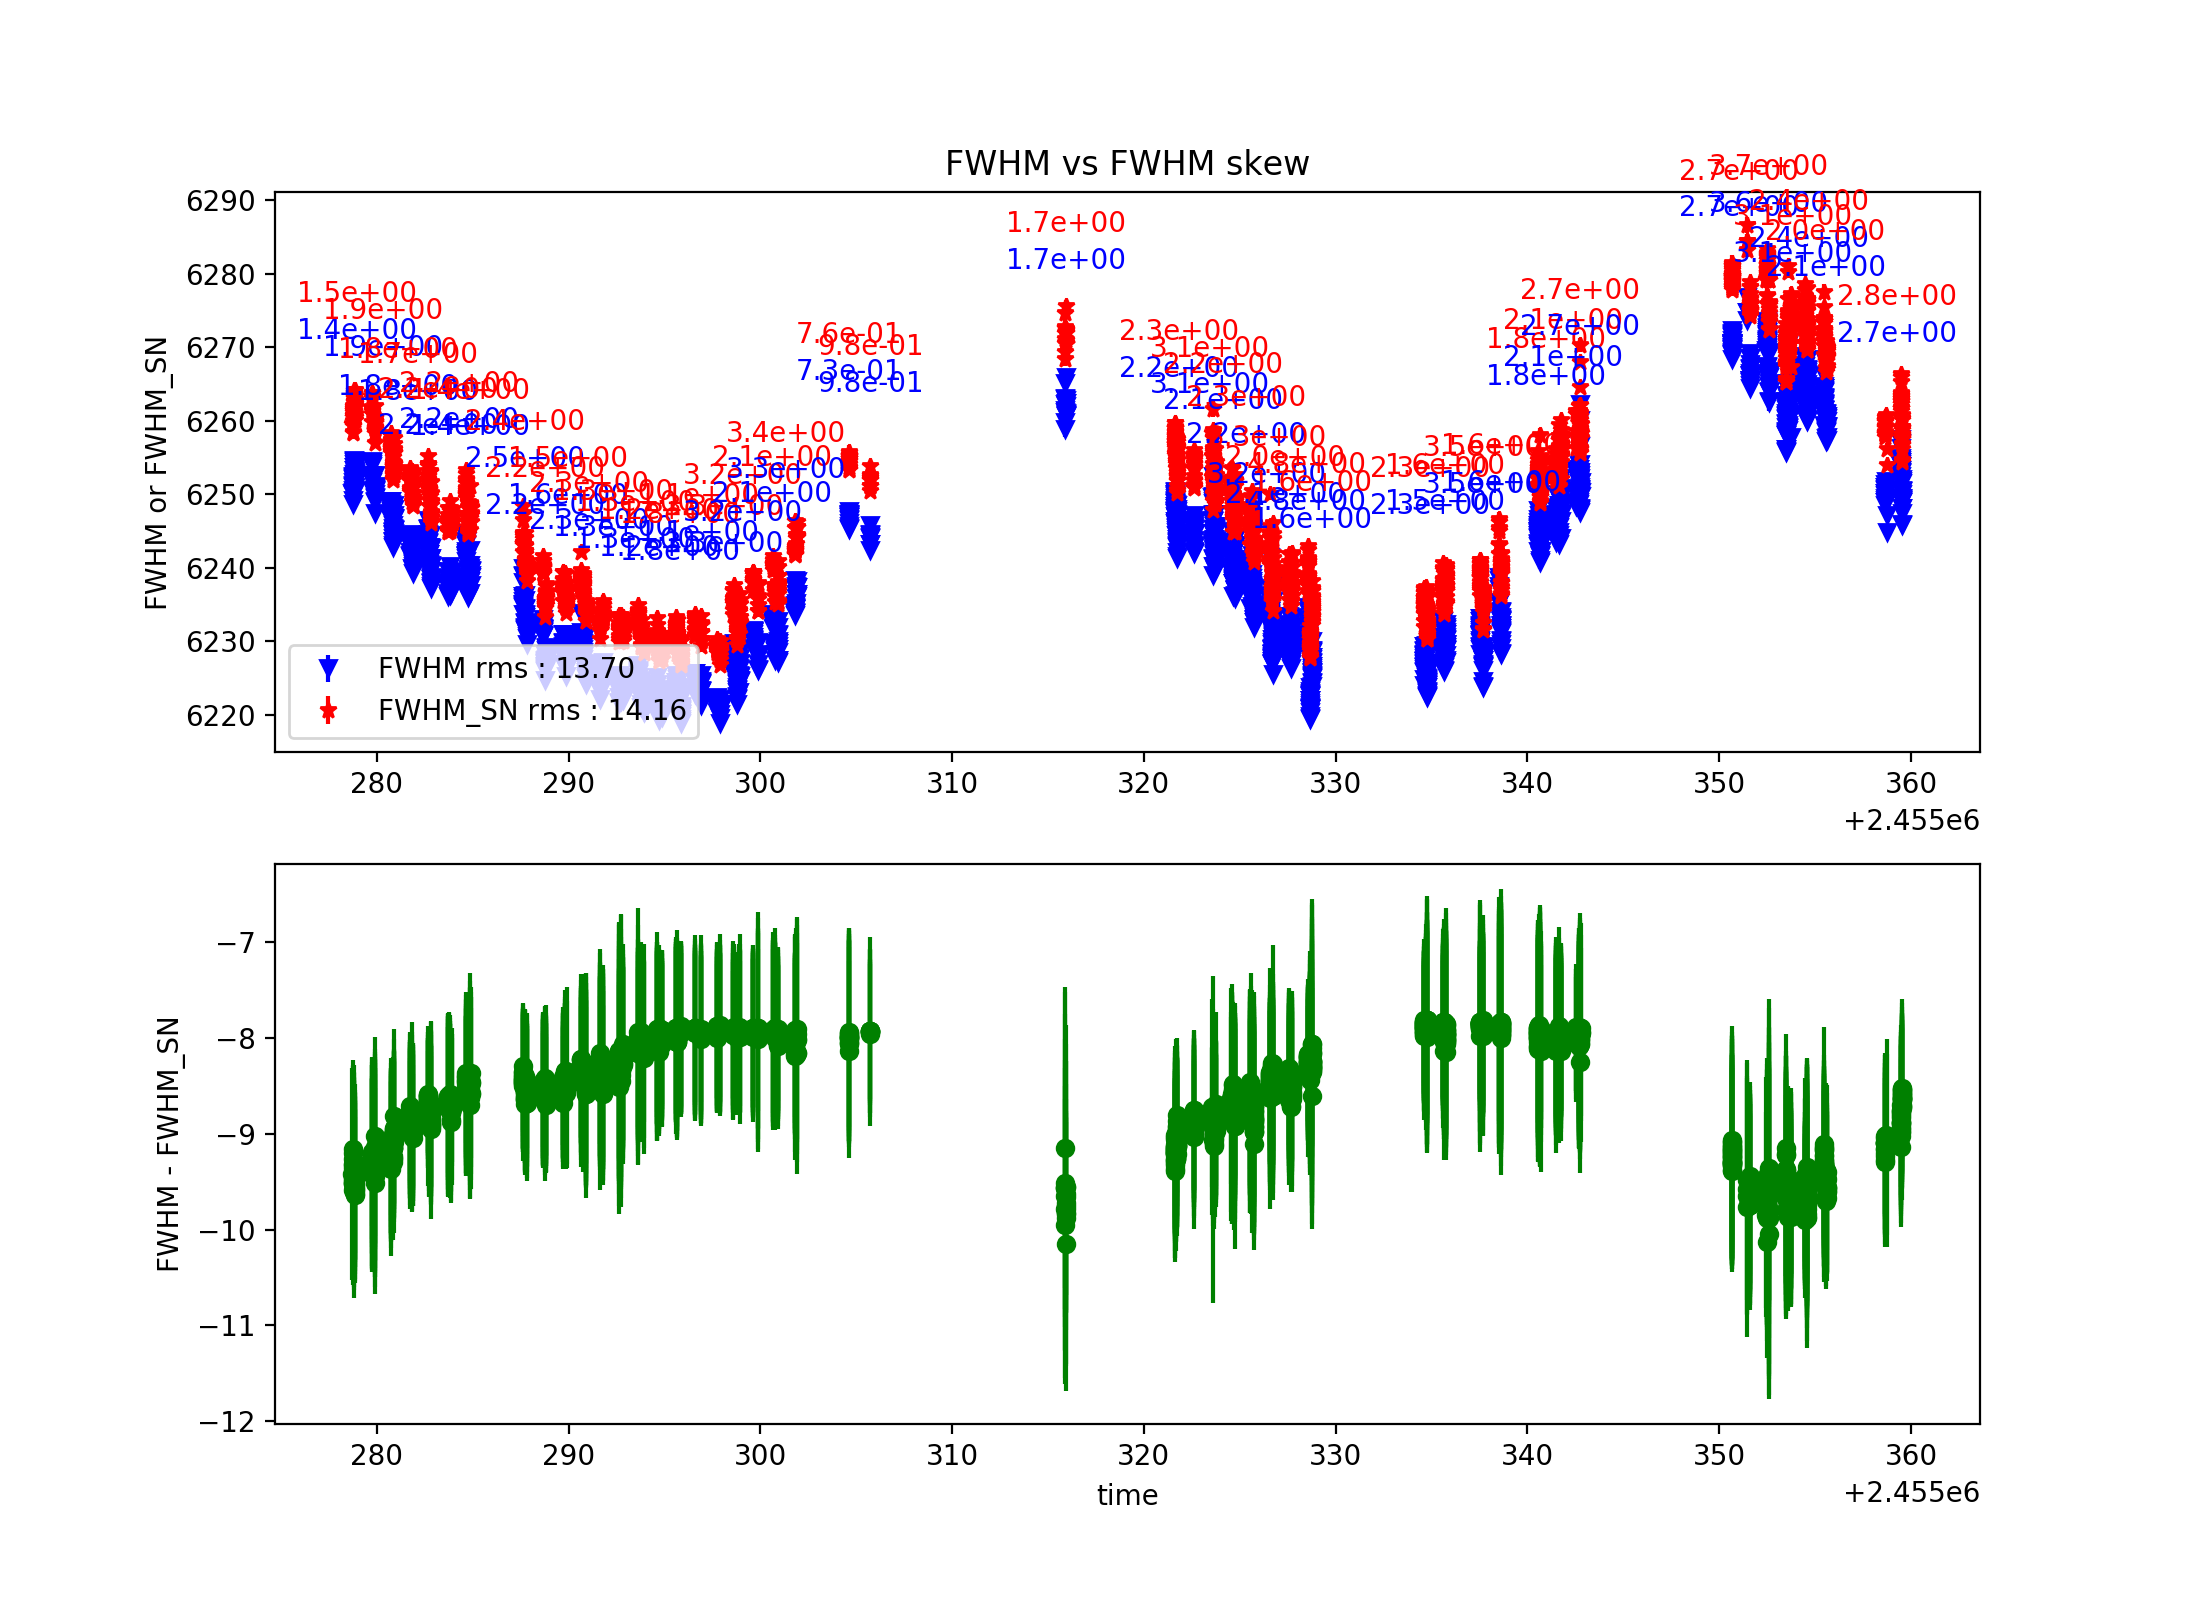

<IPython.core.display.Javascript object>


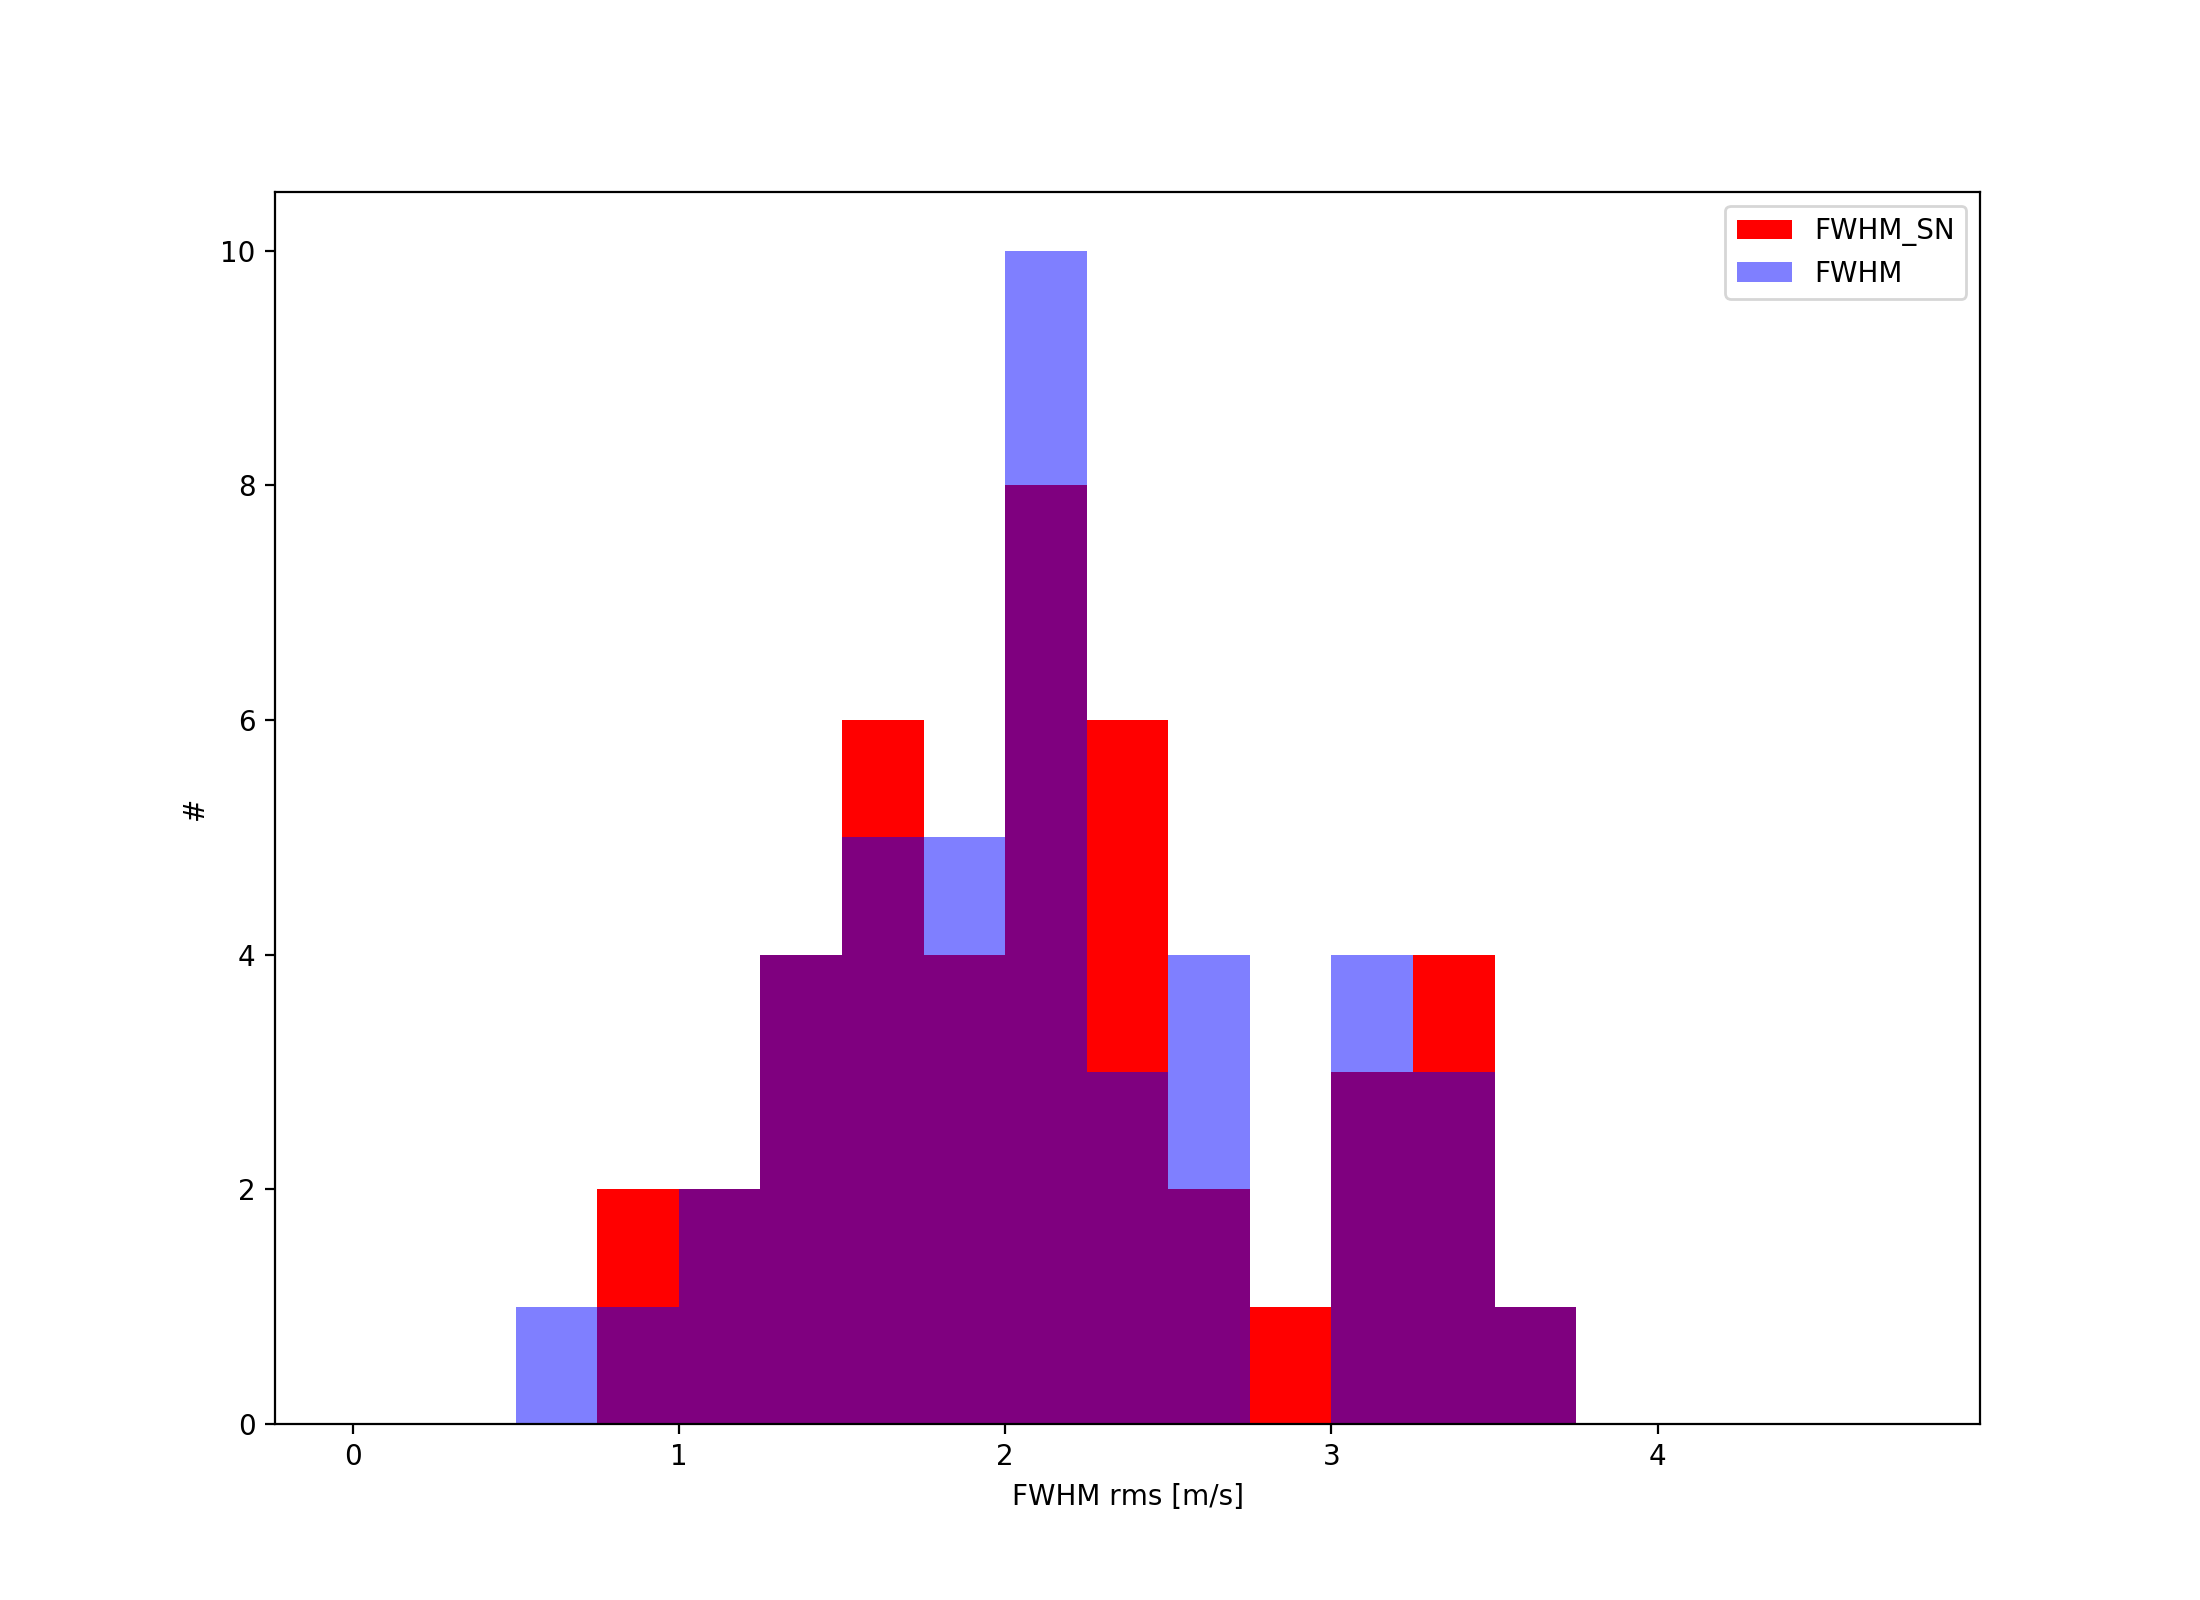

In [12]:
figure()
subplot(211)
title('FWHM vs FWHM skew')
errorbar(time,fwhm_fit,fwhm_fit_error,c='b',marker='v',ls='',label = 'FWHM rms : %.2f' % std(fwhm_fit))
errorbar(time,fwhm_skew,fwhm_skew_error,c='r',marker='*',ls='',label = 'FWHM_SN rms : %.2f' % std(fwhm_skew))
for i,(time_bin,fwhm_bin,std_fwhm,std_fwhm_skew) in enumerate(zip(time_binned,fwhm_binned,std_fwhm_bin,std_fwhm_skew_bin)):
    text(time_bin,fwhm_bin+20+i%2*1,'%.1e' % (std_fwhm),color='b',va='center',ha='center')
    text(time_bin,fwhm_bin+25+i%2*1,'%.1e' % (std_fwhm_skew),color='r',va='center',ha='center')
ylabel('FWHM or FWHM_SN')
legend(loc=3)
ax=gca()
subplot(212,sharex=ax)
errorbar(time,fwhm_fit-fwhm_skew,sqrt(fwhm_fit_error**2 + (fwhm_skew_error)**2),color='g',marker='o',ls='')
ylabel('FWHM - FWHM_SN')
xlabel('time')

figure()
bins_vect = arange(0,5,0.25)
hist(std_fwhm_skew_bin,bins=bins_vect,color='r',label='FWHM_SN')
hist(std_fwhm_bin,bins=bins_vect,color='b',alpha=0.5,label='FWHM')
legend(loc='best')
xlabel('FWHM rms [m/s]')
ylabel('#')

<IPython.core.display.Javascript object>


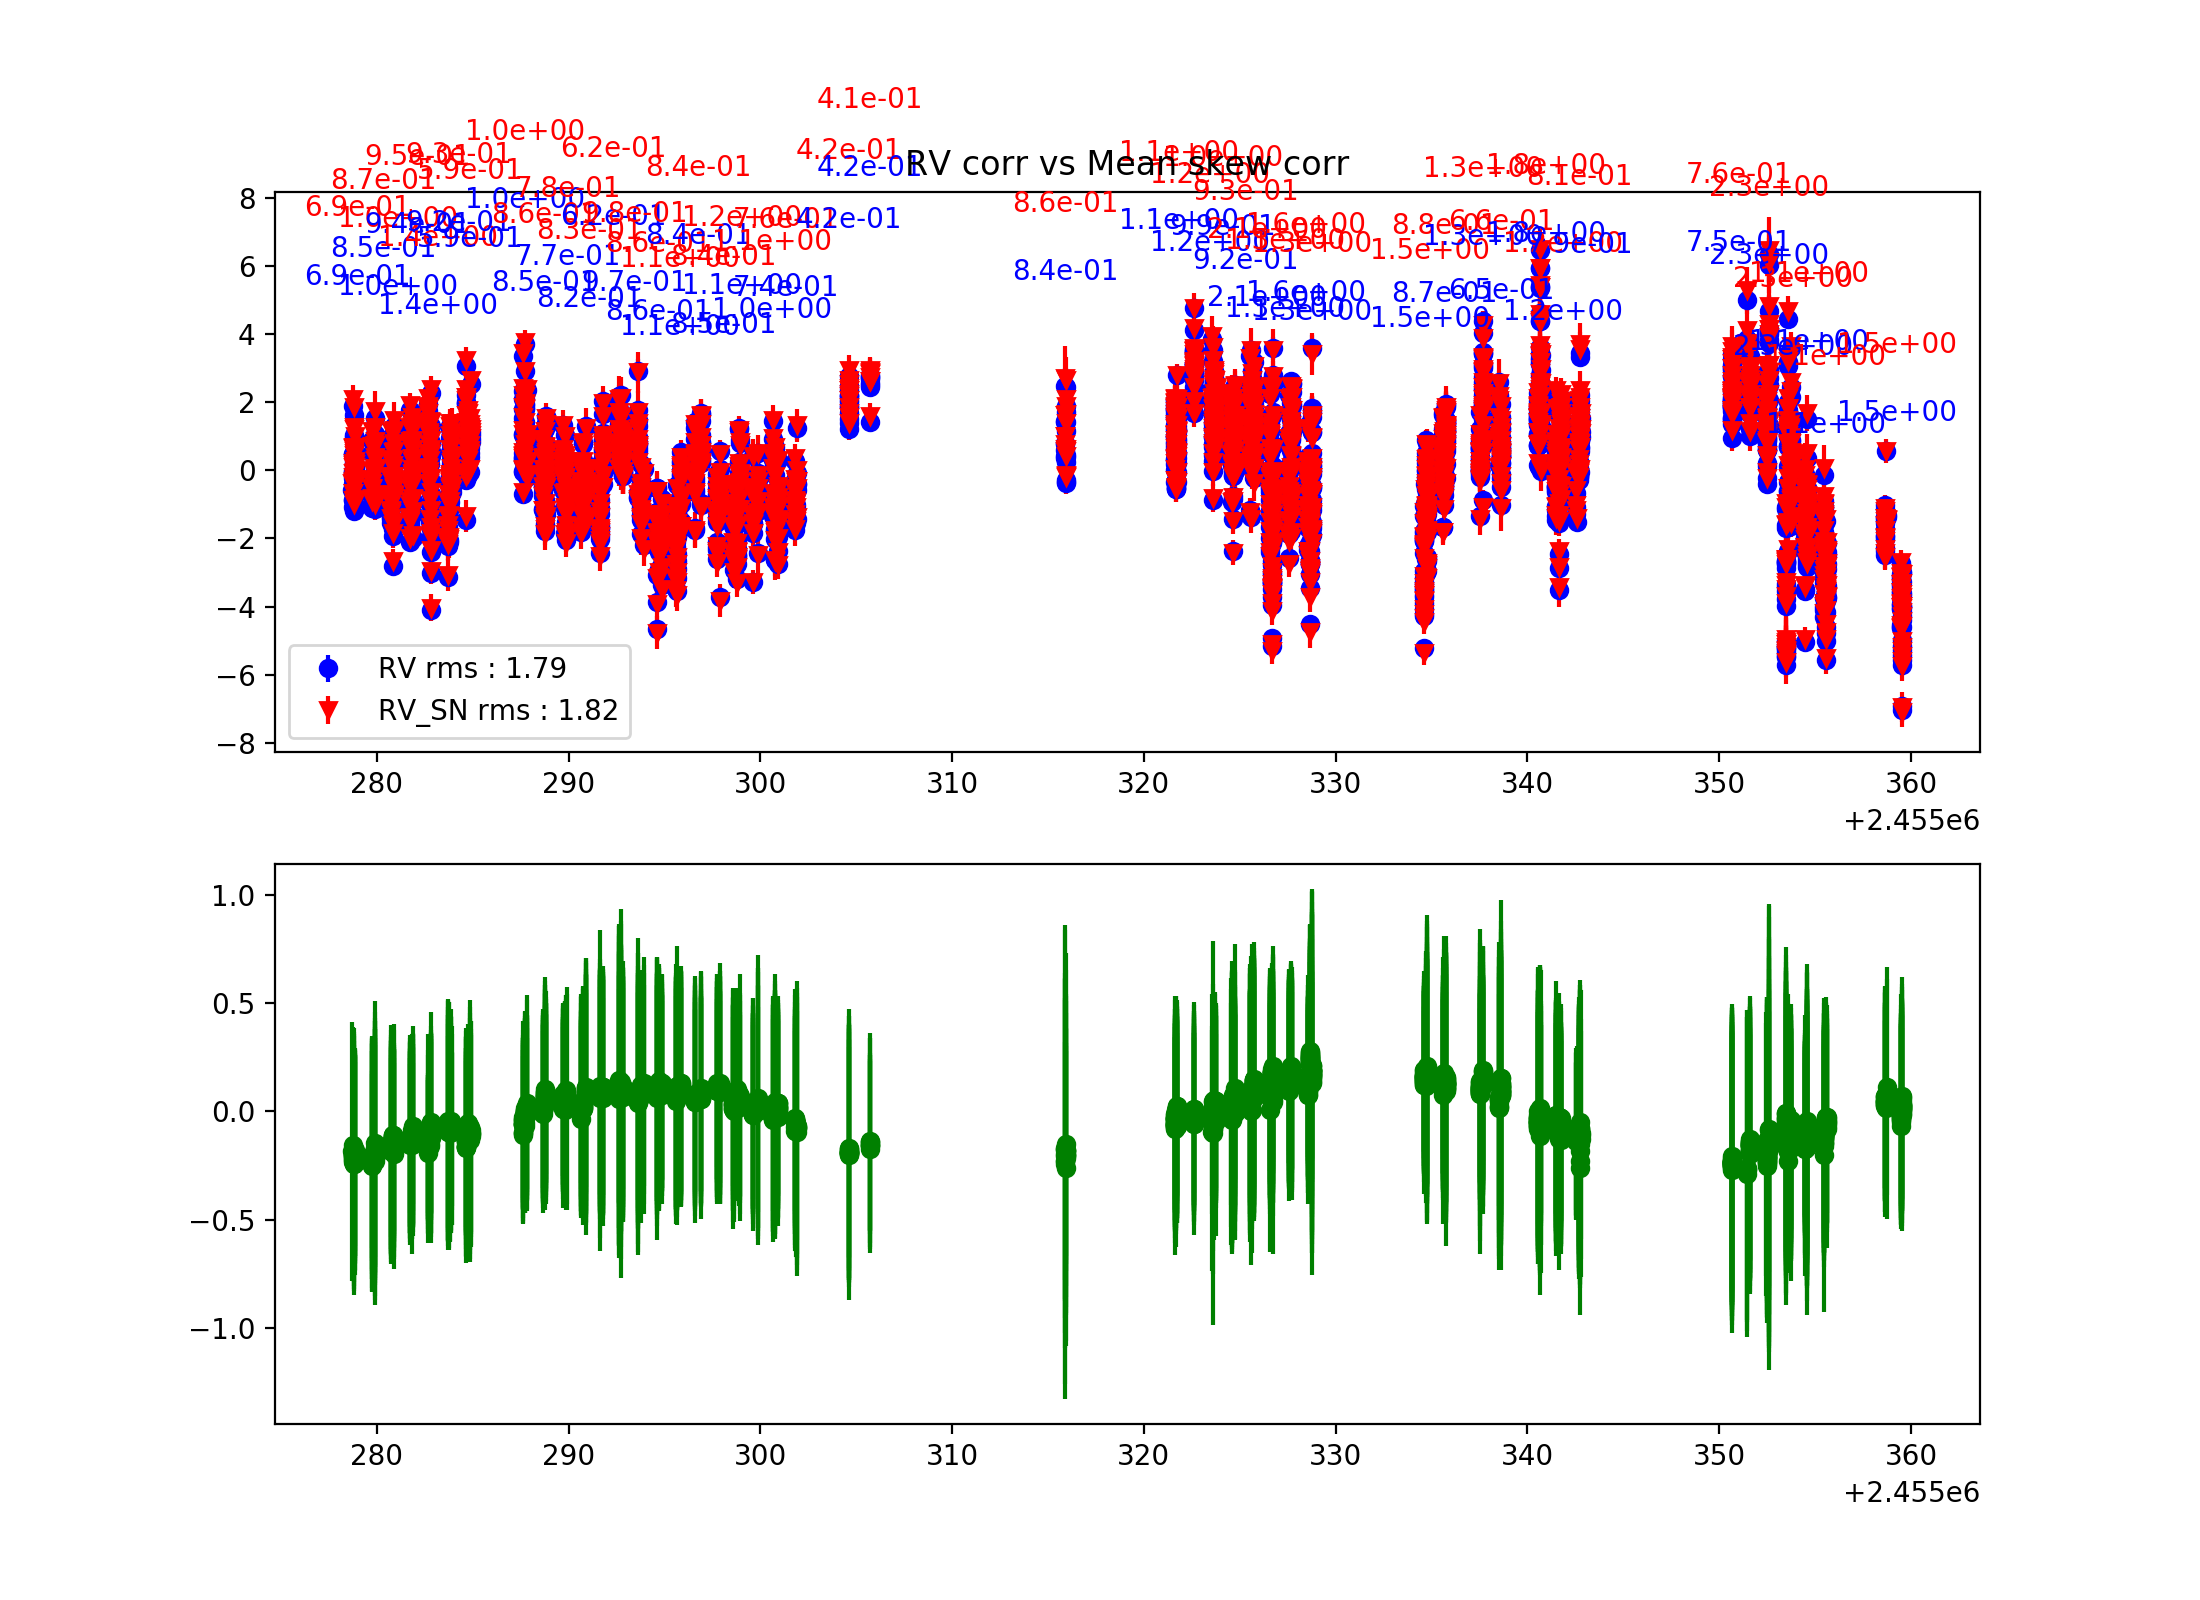

<Container object of 3 artists>

In [13]:
rv_corr -= poly1d(polyfit(time,rv_corr,1))(time)
mean_skew_corr -= poly1d(polyfit(time,mean_skew_corr,1))(time)

figure()
subplot(211)
title('RV corr vs Mean skew corr')
errorbar(time,rv_corr,rv_fit_error,color='b',marker='o',ls='',label = 'RV rms : %.2f' % std(rv_corr))
errorbar(time,mean_skew_corr,mean_skew_error,color='r',marker='v',ls='',label = 'RV_SN rms : %.2f' % std(mean_skew_corr))
for i,(time_bin,rv_bin,std_rv,std_mean_skew) in enumerate(zip(time_binned,rv_binned_corr,std_rv_bin_corr,std_mean_skew_bin_corr)):
    text(time_bin,rv_bin+5+i%2*1,'%.1e' % (std_rv),color='b',va='center',ha='center')
    text(time_bin,rv_bin+7+i%2*1,'%.1e' % (std_mean_skew),color='r',va='center',ha='center')
if len(bad_points) > 0:
    plot(time[bad_points],mean_skew_corr[bad_points],marker='o',color='g',ls='')
legend(loc=3)
ax = gca()
subplot(212,sharex=ax)
errorbar(time,rv_corr-mean_skew_corr,sqrt(rv_fit_error**2+mean_skew_error**2),marker='o',color='g',ls='')


<IPython.core.display.Javascript object>


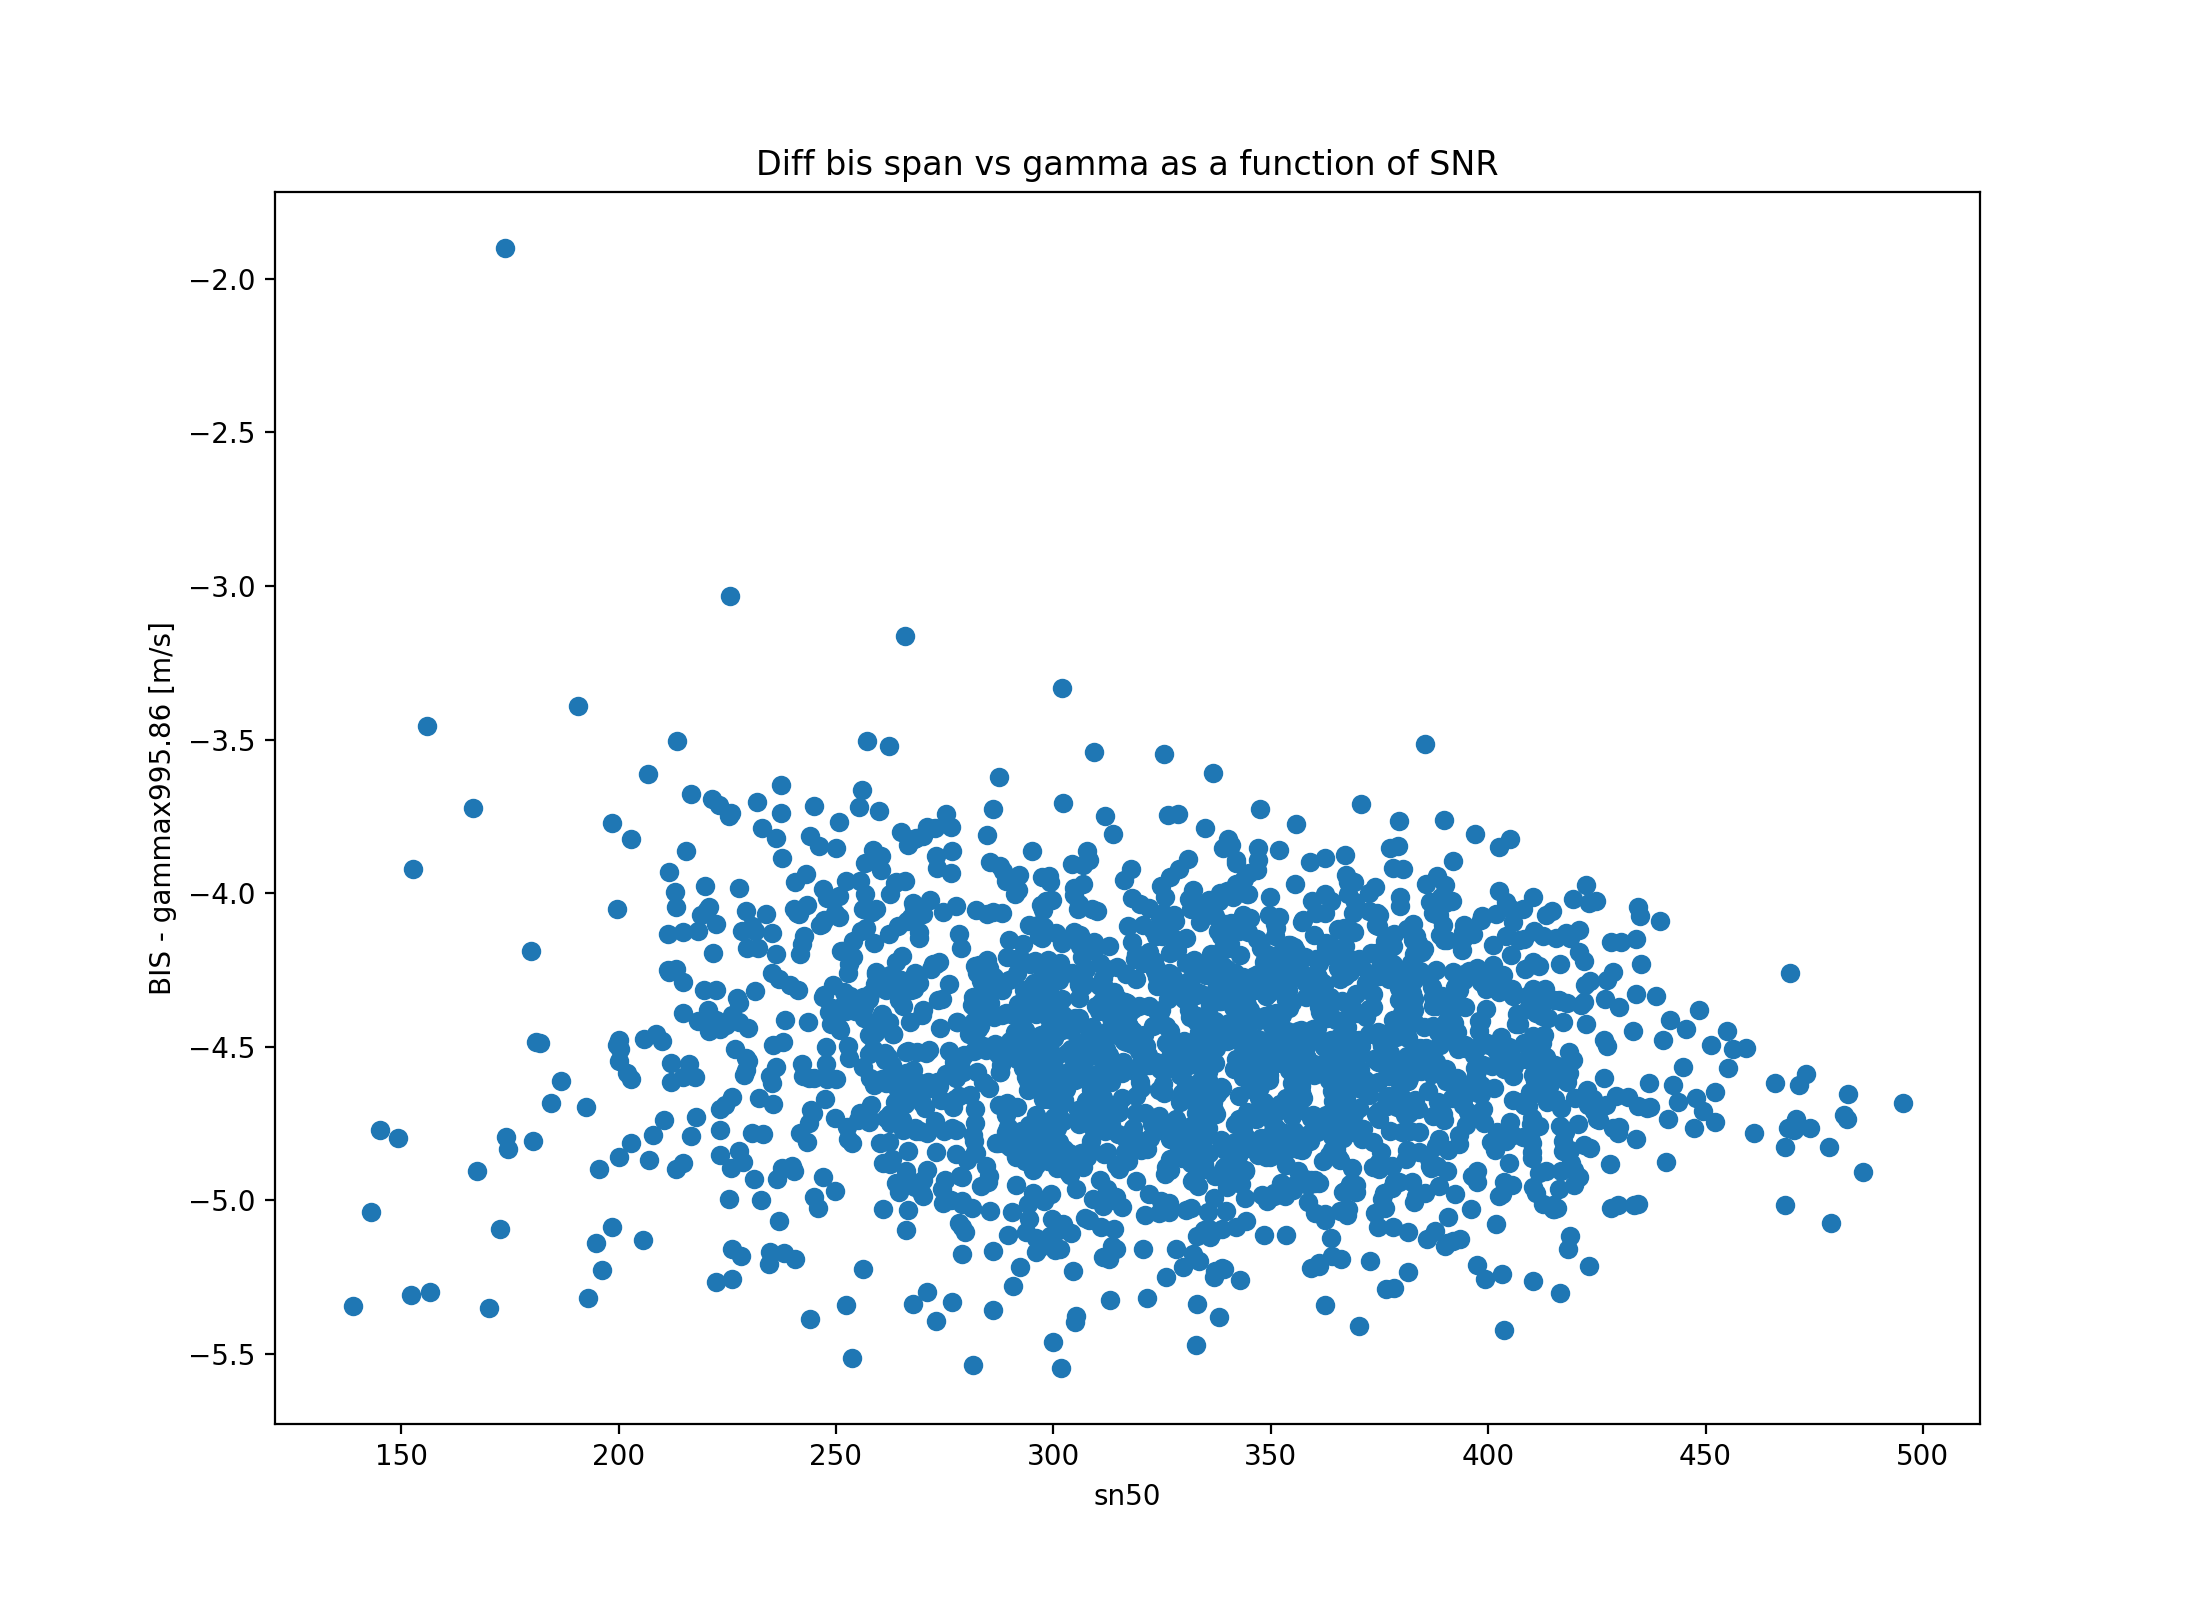

In [14]:
figure()
title('Diff bis span vs gamma as a function of SNR')
plot(sn50,bis_span_fit-gamma_skew*bis_span_gamma_ratio,'o')
xlabel('sn50')
ylabel('BIS - gammax%.2f [m/s]'% bis_span_gamma_ratio)